In [3]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
from tqdm.notebook import tqdm

from analysis_module import *
## Importing fixation analysis scripts, use help function below for function desc
# import analysis_fixation
# from importlib import reload
# reload(analysis_fixation)
from analysis_fixation import *
# help(Fixation.parse_trials)

Cell below plots single subject (s4) raw model outputs from all three models. It could be seen that the 13 grid pattern is well captured but the points need to be mapped to the presentation plane 

5.139110303190753


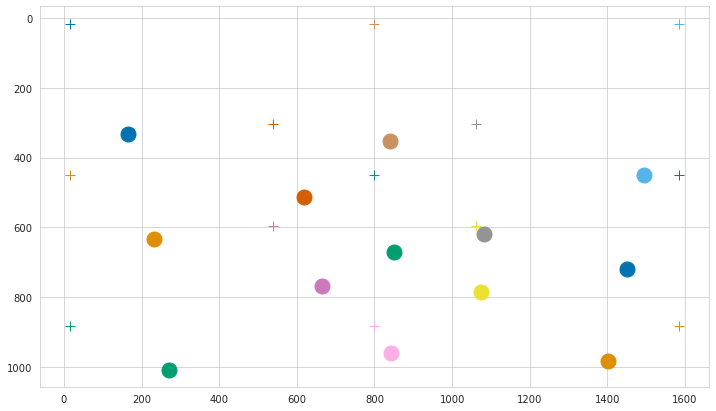

In [14]:
#Choose Gaze prediction model ETH/FAZE/MPII
model= pred_path.ETH

pallete = iter(sns.color_palette("colorblind", 13))
plt.figure(figsize=(12,7))
fix_analyse = Fixation('s4', show = False)
trial_x, trial_y, *_ = fix_analyse.parse_trials(model,model_outputs = True, col_x = "X", col_y = "Y", show = False)
print("Acc: ",get_fix_acc(fix_analyse.gt_points, trial_x, trial_y)/54.05) #in visual degrees
for key in range(1,14):
    c = next(pallete)
    pt = fix_analyse.gt_points[key-1]
    plt.plot(pt[0],pt[1], marker="+", markersize=10, color = c)
    X = winsorize(trial_x[key], limits=[0.1,0.1]).mean()
    Y = winsorize(trial_y[key], limits=[0.1,0.1]).mean()
    plt.plot(X,Y, color = c, markersize = 15, marker = "o")
plt.gca().invert_yaxis()
plt.show()

## Calib Test 1 (Sample Size)

In [18]:
model=pred_path.MPII

#Create and save dataframes for each calibration case
labels = ["Beg", "Beg+Mid", "Beg+Mid+End"]
ct1 = pd.DataFrame(columns = ["subject","factor","acc"])
for subb in tqdm(subjects): 
    fix_analyse = Fixation(subb, show = False)
    for factor in [1,2,3]:
        trial_x, trial_y, *_ = fix_analyse.parse_trials(model, col_x=f"poly_x_{factor}", col_y=f"poly_y_{factor}", calib_test=1, show = False)
        acc = get_fix_acc(fix_analyse.gt_points, trial_x, trial_y)
        ct1 = ct1.append({"subject":subb, "factor": labels[factor-1], "acc":acc}, ignore_index = True)
ct1.to_csv(f"calib_tests_df/{model.name.lower()}_ct1.csv", index = False)

100%|██████████| 65/65 [25:35<00:00, 23.62s/it]


In [318]:
## Loaf dfs
ct1_mpii = pd.read_csv("calib_tests_df/mpii_ct1.csv")
ct1_eth = pd.read_csv("calib_tests_df/eth_ct1.csv")
ct1_faze = pd.read_csv("calib_tests_df/faze_ct1.csv")

In [248]:
#Worst performing subject accuracies are different for each model 
pd.concat([d.sort_values('acc',ascending = False).head(10).reset_index(drop=True) for d in [ct1_mpii, ct1_eth, ct1_faze]], axis=1, keys=["MPII","ETH","FAZE"])

MPII                               ETH                              FAZE  \
  subject       factor          acc subject       factor          acc subject   
0     s82          Beg  1130.778015     s63          Beg  1127.377607     s64   
1    s104          Beg   826.590546     s61  Beg+Mid+End  1060.965702     s64   
2     s64          Beg   658.513819     s61      Beg+Mid  1040.797943     s64   
3      s9          Beg   647.131781     s59          Beg   854.487662     s86   
4     s64      Beg+Mid   611.141058     s61          Beg   854.226442     s87   
5     s64  Beg+Mid+End   605.844827     s87  Beg+Mid+End   681.672578      s9   
6     s82  Beg+Mid+End   583.955563     s59      Beg+Mid   665.883019     s78   
7     s82      Beg+Mid   573.892317     s81  Beg+Mid+End   634.904007     s59   
8      s9      Beg+Mid   500.533158     s87      Beg+Mid   630.966853     s63   
9      s9  Beg+Mid+End   485.871657     s81      Beg+Mid   610.191935     s58   

                            
        factor         acc  
0          Beg  637.855327  
1      Beg+Mid  607.857423  
2  Beg+Mid+End  596.121083  
3          Beg  473.391246  
4          Beg  447.005368  
5          Beg  366.497445  
6          Beg  316.817545  
7          Beg  313.091316  
8          Beg  308.519757  
9          Beg  304.922977

<AxesSubplot:xlabel='subject'>

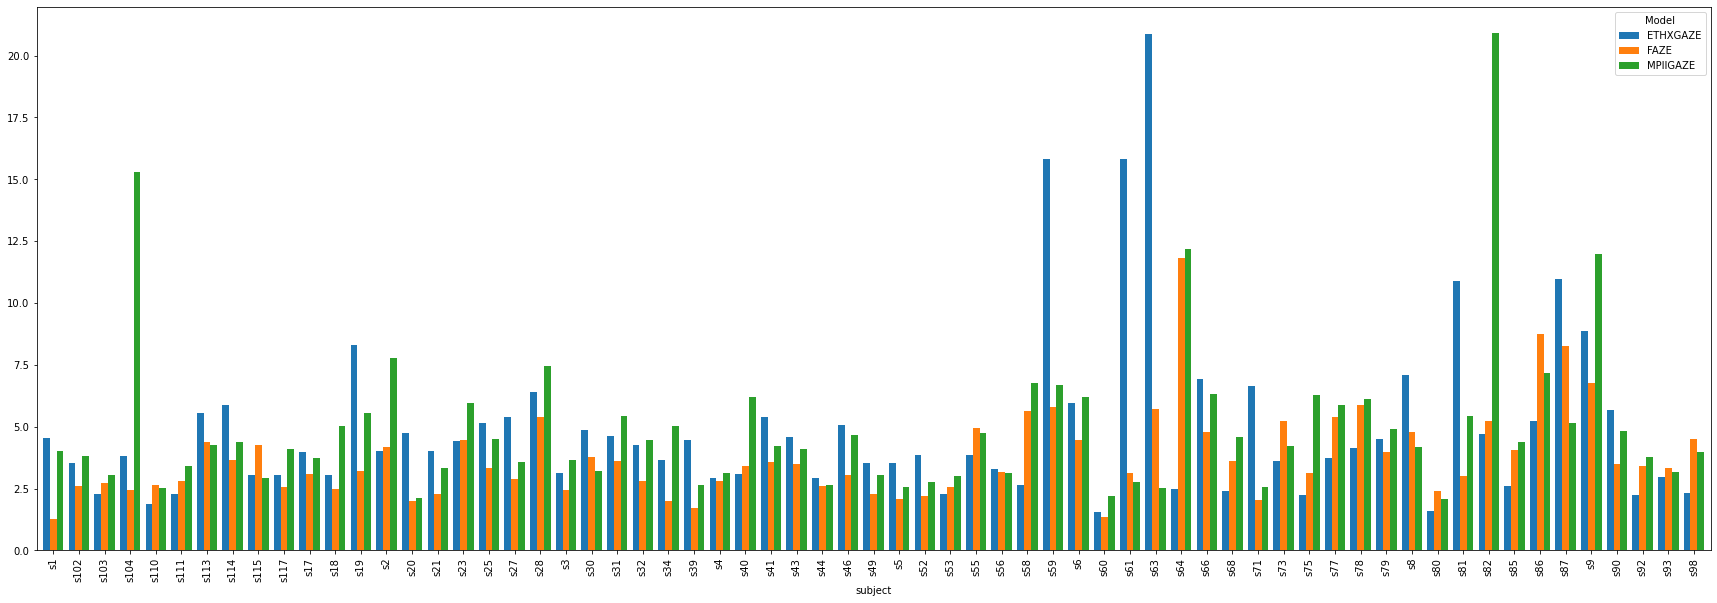

In [68]:
temp = pd.concat([ct1_mpii, ct1_eth, ct1_faze], keys=["MPIIGAZE", "ETHXGAZE", "FAZE"], names=["Model"]).reset_index()
temp["acc_deg"] = temp["acc"]/54.05
temp[temp["factor"] == "Beg"].pivot(index="subject", columns="Model", values="acc_deg").plot(kind="bar", figsize=(30,10), width=0.8)

In [69]:
def ct1_run_tests(ct1_df, in_vis_deg = False, exclude_low_fps = False, pal = sns.color_palette('deep', 3)):
    ct1_df = ct1_df.copy()
    if in_vis_deg: 
        ct1_df["acc_deg"] = ct1_df.acc/54.05
        target = 'acc_deg'
    else: target = 'acc'
    
    if exclude_low_fps: #test parameter
        ct1_df = ct1_df[~ct1_df.subject.isin(low_fps_subb)]
    
    print(ct1_df.groupby("factor")[target].agg(['count', 'max', 'mean', 'min', 'std']))
    print(AnovaRM(data=ct1_df, depvar='acc', subject='subject', within=['factor']).fit()) #depvar for ANOVA is acc
    sns.set(rc={'figure.figsize':(16,12)})
    sns.boxplot(x="factor", y=target, data = ct1_df, color=pal[2], showfliers = False)
    sns.swarmplot(x="factor", y=target, data = ct1_df, color = pal[0])
    plt.show()

             count        max      mean       min       std
factor                                                     
Beg             65  20.920962  4.965501  2.080064  3.097902
Beg+Mid         65  11.306958  4.258988  1.836741  1.847173
Beg+Mid+End     65  11.208970  4.159439  1.778638  1.834301
                Anova
       F Value Num DF  Den DF  Pr > F
-------------------------------------
factor 11.0505 2.0000 128.0000 0.0000



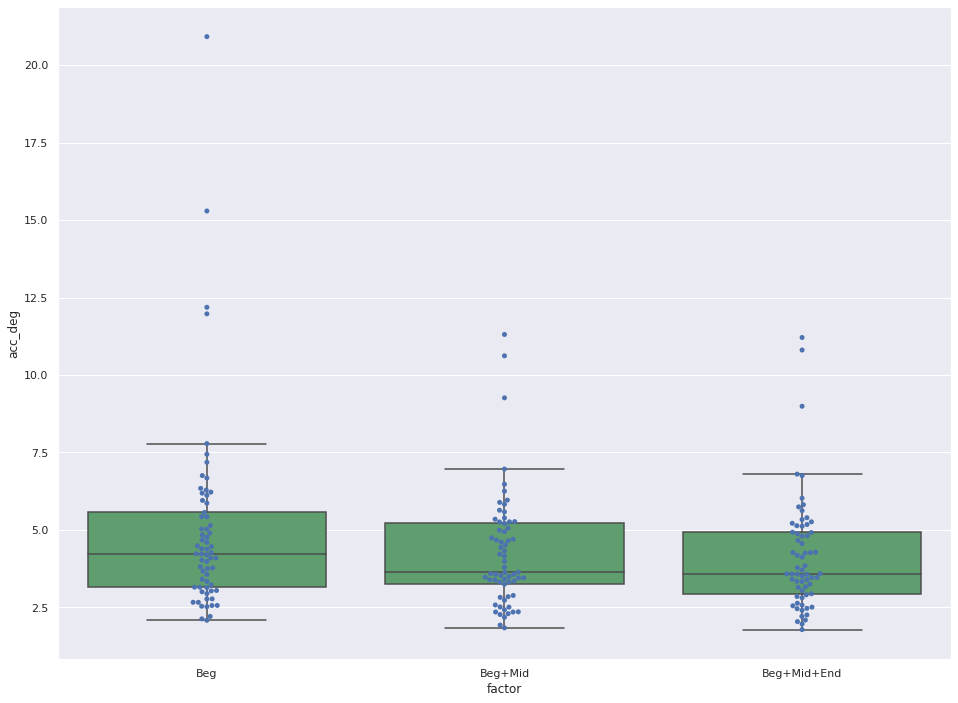

             count        max      mean       min       std
factor                                                     
Beg             65  20.858050  4.909537  1.569801  3.432871
Beg+Mid         65  19.256206  4.254357  1.527371  2.832920
Beg+Mid+End     65  19.629338  4.085426  1.432692  2.810484
                Anova
       F Value Num DF  Den DF  Pr > F
-------------------------------------
factor  7.7926 2.0000 128.0000 0.0006



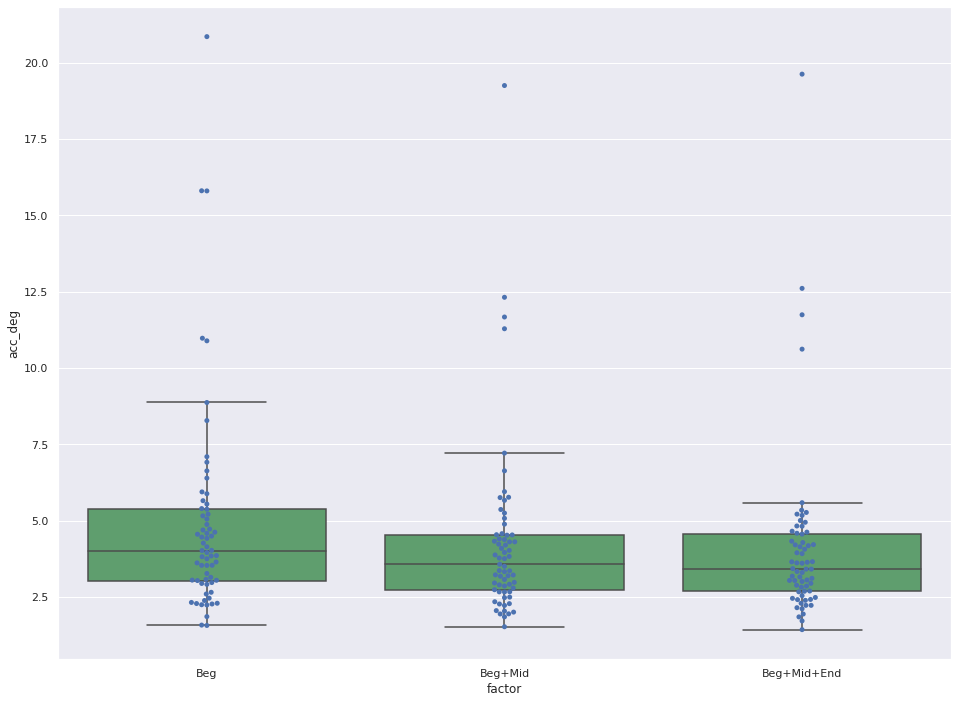

             count        max      mean       min       std
factor                                                     
Beg             65  11.801209  3.771809  1.273206  1.801922
Beg+Mid         65  11.246206  2.992425  1.283358  1.417379
Beg+Mid+End     65  11.029067  2.821400  1.398690  1.389888
                Anova
       F Value Num DF  Den DF  Pr > F
-------------------------------------
factor 52.9839 2.0000 128.0000 0.0000



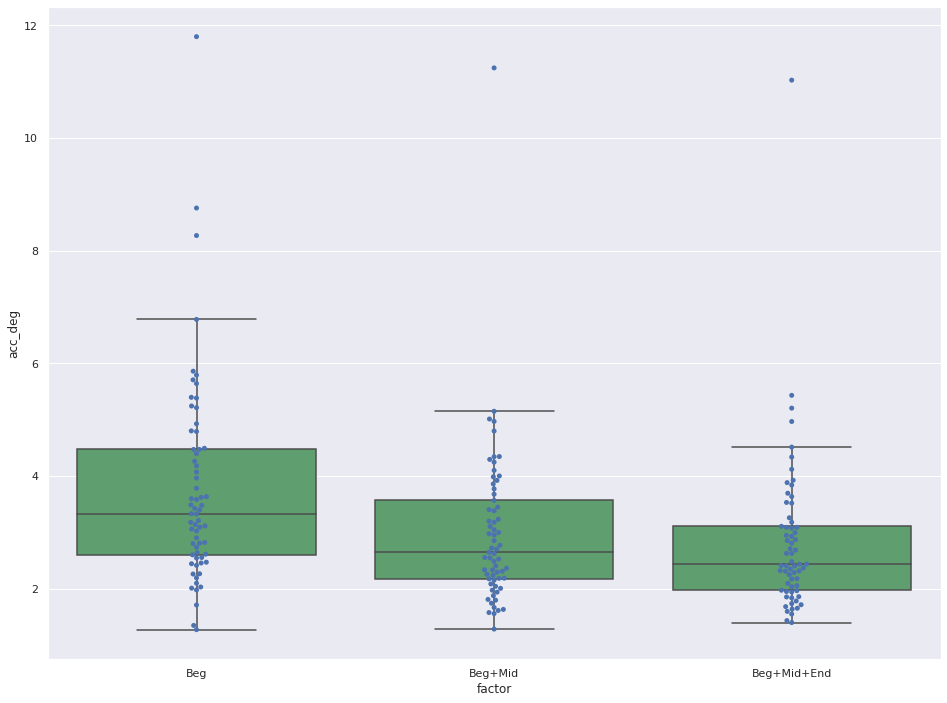

In [70]:
#Run statistical tests
ct1_run_tests(ct1_mpii, in_vis_deg=True)
ct1_run_tests(ct1_eth, in_vis_deg=True)
ct1_run_tests(ct1_faze, in_vis_deg=True)

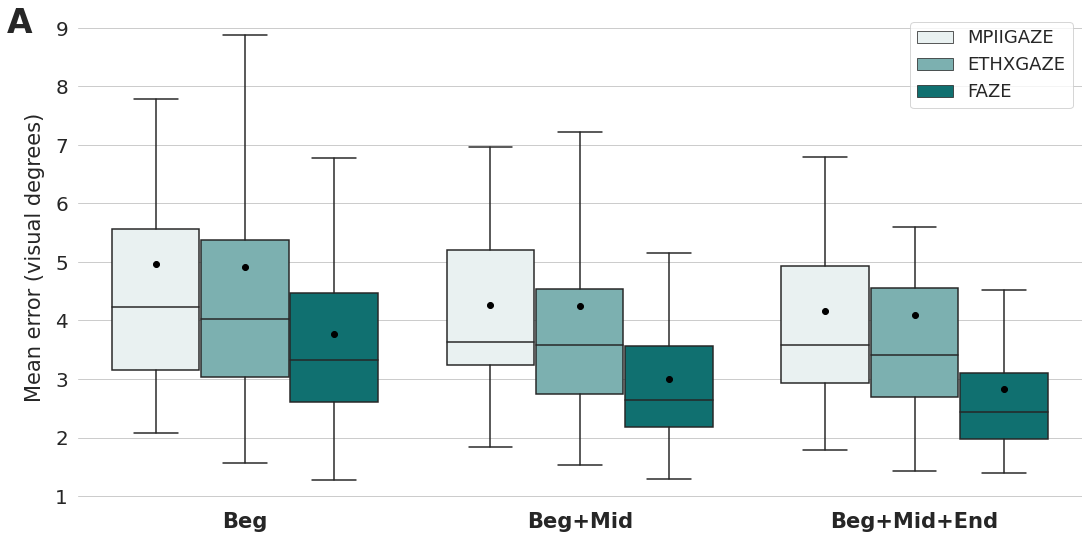

In [367]:
#Complete 65 subjects, E_calib
plt.figure(figsize=(18,9))
temp = pd.concat([ct1_mpii, ct1_eth, ct1_faze], keys=["MPIIGAZE", "ETHXGAZE", "FAZE"], names=["Model"]).reset_index()
temp["acc_deg"] = temp.acc/54.05
sns.boxplot(x="factor", y="acc_deg", hue="Model", data = temp, color="teal", showfliers = False,  showmeans=True, meanprops={"marker":"o", "markerfacecolor":"black", "markeredgecolor":"black"})
plt.xticks(fontsize=21, fontweight = 800)
plt.yticks(fontsize = 20, fontweight = 520)
plt.legend(fontsize=18)
plt.xlabel('')
plt.ylabel('Mean error (visual degrees)', fontsize=21, fontweight = 549, labelpad=10)
plt.title("A", loc='left', position = (-0.07,0), fontsize=33, fontweight=550, va = 'top')
# plt.ylim([0,10])
sns.despine(left=True, bottom=True)
plt.savefig("calib_final_plots/calibtest1.png", dpi = 300,bbox_inches='tight')

Text(0, 0.5, '')

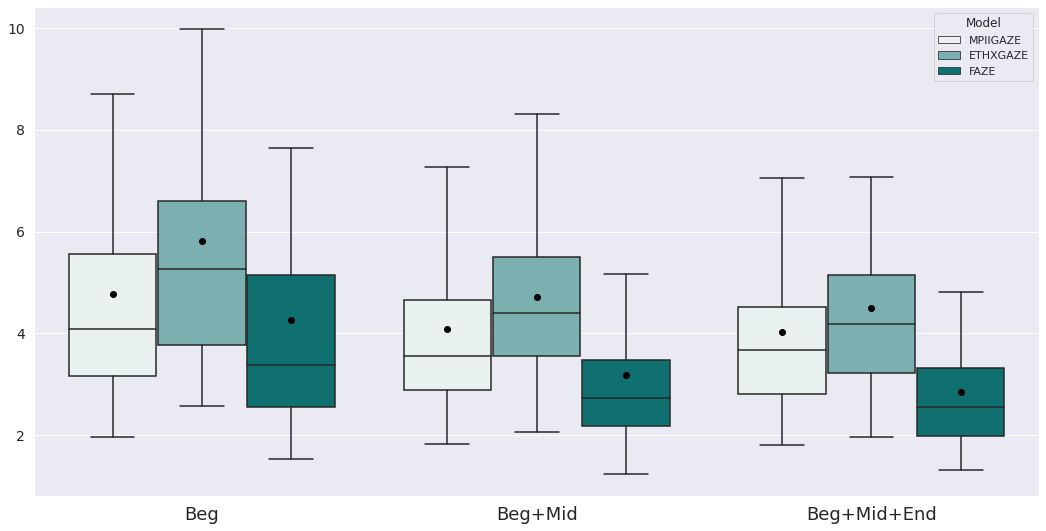

In [ ]:
#Complete 65 subjects SP_calib
plt.figure(figsize=(18,9))
temp = pd.concat([ct1_mpii, ct1_eth, ct1_faze], keys=["MPIIGAZE", "ETHXGAZE", "FAZE"], names=["Model"]).reset_index()
temp["acc_deg"] = temp.acc/54.05
sns.boxplot(x="factor", y="acc_deg", hue="Model", data = temp, color="teal", showfliers = False,  showmeans=True, meanprops={"marker":"o", "markerfacecolor":"black", "markeredgecolor":"black"})
plt.xticks(fontsize=21, fontweight = 800)
plt.yticks(fontsize = 20, fontweight = 520)
plt.legend(fontsize=18)
plt.xlabel('')
plt.ylabel('Mean error (visual degrees)', fontsize=21, fontweight = 549, labelpad=10)
# plt.ylim([0,10])

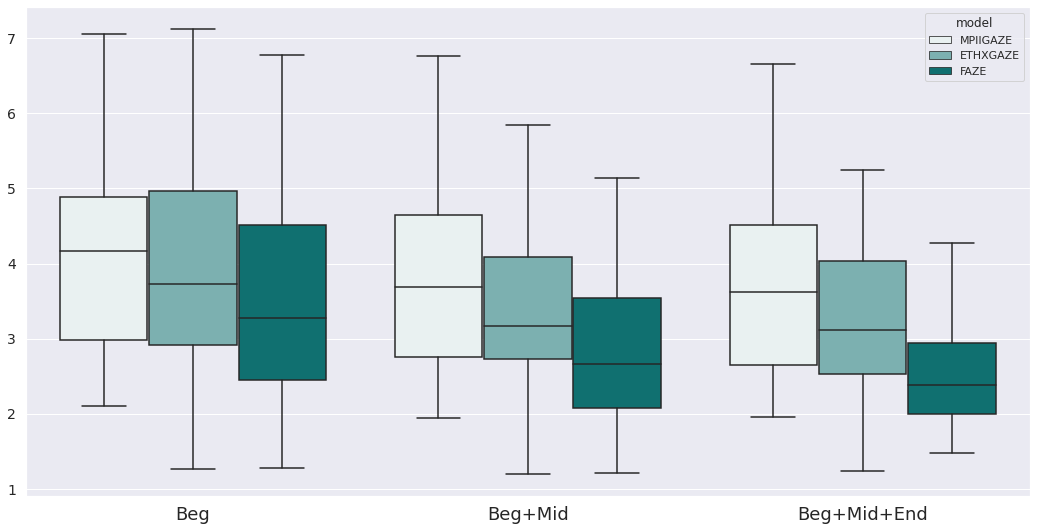

In [90]:
##ETRA 41 Subjects
plt.figure(figsize=(18,9))
temp = pd.concat([ct1_mpii, ct1_eth, ct1_faze], keys=["MPIIGAZE", "ETHXGAZE", "FAZE"], names=["Model"]).reset_index()
temp["acc_deg"] = temp.acc/54.05
sns.boxplot(x="factor", y="acc_deg", hue="Model", data = temp, color="teal", showfliers = False)
plt.xticks(fontsize=18)
plt.yticks(fontsize = 14)
plt.xlabel(''); plt.ylabel('')
# sns.swarmplot(x="factor", y="acc_deg", hue="model", data = temp, color = pal[0])
# plt.ylim([0,10])

In [74]:
# ct1_comb all data for 2 Factor anova
ct1_comb = pd.merge(ct1_mpii,ct1_eth, on = ["subject", "factor"]).merge(ct1_faze, on = ["subject", "factor"])
ct1_comb = ct1_comb.set_index(["subject","factor"]).stack().reset_index()
ct1_comb.columns = ["subject","factor_sample","factor_model","acc"]
ct1_comb["factor_model"].replace({"acc_x": "mpii", "acc_y":"eth", "acc":"faze"}, inplace = True)
print(AnovaRM(data=ct1_comb, depvar='acc', subject='subject', within=['factor_sample', 'factor_model']).fit())

                          Anova
                           F Value Num DF  Den DF  Pr > F
---------------------------------------------------------
factor_sample              34.1687 2.0000 128.0000 0.0000
factor_model                9.0025 2.0000 128.0000 0.0002
factor_sample:factor_model  0.1395 4.0000 256.0000 0.9675



In [75]:
from pingouin import rm_anova #Same test diff library
rm_anova(data=ct1_comb, dv = 'acc', within = ['factor_sample', 'factor_model'], subject='subject', detailed = True, effsize = 'n2')

/home/shreshth.saxena/.conda/envs/temp/lib/python3.7/site-packages/pingouin/distribution.py:485: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,n2,eps
0,factor_sample,241304.85593,2,128,120652.427965,34.168744,1.285972e-12,6.128759e-08,0.039272,0.546474
1,factor_model,587982.30381,2,128,293991.151905,9.002479,2.197411e-04,1.483879e-03,0.095694,0.665241
2,factor_sample * factor_model,1485.61392,4,256,371.403480,0.139489,9.674537e-01,7.100564e-01,0.000242,0.243499


In [76]:
mpii = ct1_mpii[["subject","acc"]].groupby("subject").mean()
eth = ct1_eth[["subject","acc"]].groupby("subject").mean()
faze = ct1_faze[["subject","acc"]].groupby("subject").mean()

mpii["model"] = "MPII"; eth["model"] = "ETHXGaze"; faze["model"] = "FAZE" 
avg_models = mpii.append(eth).append(faze).sort_values("subject")
print(pg.pairwise_ttests(dv='acc', within='model', subject='subject', padjust='bonf', data = avg_models).to_markdown())

|    | Contrast   | A        | B    | Paired   | Parametric   |         T |   dof | alternative   |       p-unc |      p-corr | p-adjust   |       BF10 |     hedges |
|---:|:-----------|:---------|:-----|:---------|:-------------|----------:|------:|:--------------|------------:|------------:|:-----------|-----------:|-----------:|
|  0 | model      | ETHXGaze | FAZE | True     | True         |  3.37336  |    64 | two-sided     | 0.00126465  | 0.00379394  | bonf       | 21.106     |  0.533208  |
|  1 | model      | ETHXGaze | MPII | True     | True         | -0.107126 |    64 | two-sided     | 0.915024    | 1           | bonf       |  0.137     | -0.0175751 |
|  2 | model      | FAZE     | MPII | True     | True         | -6.54156  |    64 | two-sided     | 1.17737e-08 | 3.53212e-08 | bonf       |  1.036e+06 | -0.678305  |


In [77]:
avg_samples = ct1_mpii.append(ct1_eth).append(ct1_faze)

avg_samples = avg_samples.groupby(["subject","factor"]).mean().reset_index()

print(pg.pairwise_ttests(dv='acc', within='factor', subject='subject', padjust='bonf', data = avg_samples).to_markdown())

|    | Contrast   | A       | B           | Paired   | Parametric   |       T |   dof | alternative   |       p-unc |      p-corr | p-adjust   |       BF10 |    hedges |
|---:|:-----------|:--------|:------------|:---------|:-------------|--------:|------:|:--------------|------------:|------------:|:-----------|-----------:|----------:|
|  0 | factor     | Beg     | Beg+Mid     | True     | True         | 5.59803 |    64 | two-sided     | 4.86903e-07 | 1.46071e-06 | bonf       |  30480     | 0.403291  |
|  1 | factor     | Beg     | Beg+Mid+End | True     | True         | 6.13473 |    64 | two-sided     | 5.95256e-08 | 1.78577e-07 | bonf       | 222300     | 0.49218   |
|  2 | factor     | Beg+Mid | Beg+Mid+End | True     | True         | 4.10123 |    64 | two-sided     | 0.000118276 | 0.000354828 | bonf       |    182.026 | 0.0958518 |


In [78]:
import pingouin as pg
print(pg.pairwise_ttests(dv='acc', within='factor', subject='subject', padjust='bonf', data = ct1_mpii).to_markdown())
print(pg.pairwise_ttests(dv='acc', within='factor', subject='subject', padjust='bonf', data = ct1_eth).to_markdown())
print(pg.pairwise_ttests(dv='acc', within='factor', subject='subject', padjust='bonf', data = ct1_faze).to_markdown())

|    | Contrast   | A       | B           | Paired   | Parametric   |       T |   dof | alternative   |       p-unc |     p-corr | p-adjust   |   BF10 |    hedges |
|---:|:-----------|:--------|:------------|:---------|:-------------|--------:|------:|:--------------|------------:|-----------:|:-----------|-------:|----------:|
|  0 | factor     | Beg     | Beg+Mid     | True     | True         | 3.10544 |    64 | two-sided     | 0.00283036  | 0.00849109 | bonf       | 10.279 | 0.275394  |
|  1 | factor     | Beg     | Beg+Mid+End | True     | True         | 3.54051 |    64 | two-sided     | 0.000750513 | 0.00225154 | bonf       | 33.772 | 0.314772  |
|  2 | factor     | Beg+Mid | Beg+Mid+End | True     | True         | 2.79197 |    64 | two-sided     | 0.0068992   | 0.0206976  | bonf       |  4.69  | 0.0537636 |
|    | Contrast   | A       | B           | Paired   | Parametric   |       T |   dof | alternative   |      p-unc |    p-corr | p-adjust   |   BF10 |    hedges |
|---:|:-----

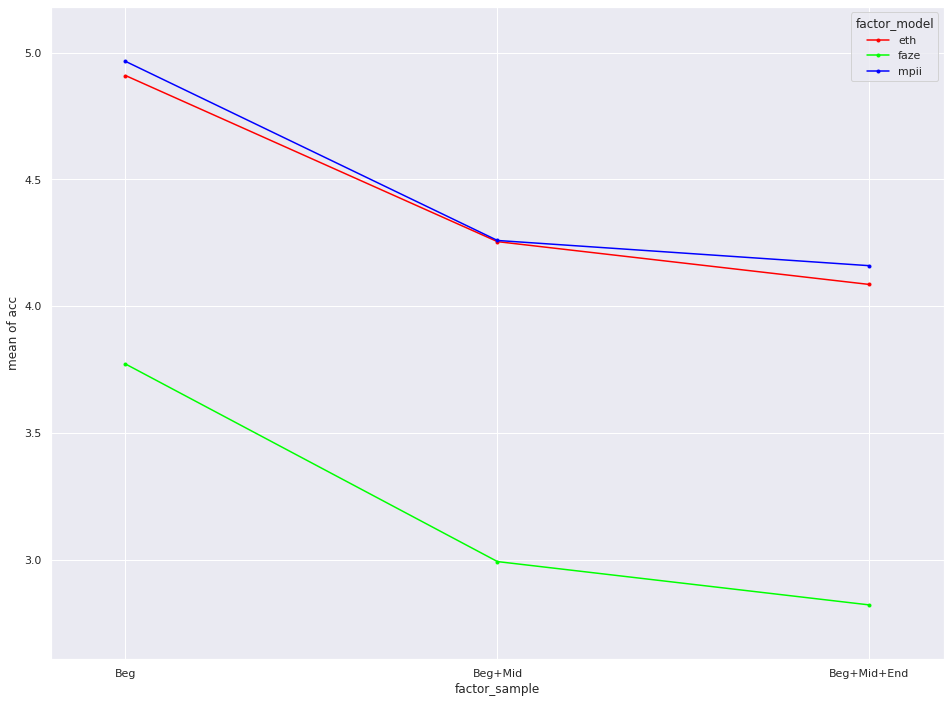

In [79]:
from statsmodels.graphics.factorplots import interaction_plot
interaction_plot(ct1_comb["factor_sample"], ct1_comb["factor_model"], ct1_comb["acc"]/54.05)
plt.show()

## Calib Test 2 (Collection time)

In [81]:
##Create Dataframes for Beg+Mid+End vs Blockwise
model=pred_path.MPII
labels = ["Beg+Mid+End", "BlockWise"] #Beg, Mid, End
ct2 = pd.DataFrame(columns = ["subject","factor","acc"])
for subb in tqdm(subjects): 
    fix_analyse = Fixation(subb, show = False)
    for test,col in zip([1,2], [("poly_x_3", "poly_y_3"), ("poly_x","poly_y")]): #UPDATE from best results of calib_test1
        trial_x, trial_y, *_ = fix_analyse.parse_trials(model, col_x = col[0], col_y=col[1], calib_test=test, show = False)
        acc = get_fix_acc(fix_analyse.gt_points, trial_x, trial_y)
        ct2 = ct2.append({"subject":subb, "factor": labels[test-1], "acc":acc}, ignore_index = True)
ct2.to_csv(f"calib_tests_df/{model.name.lower()}_ct2.csv", index = False)


 58%|█████▊    | 38/65 [15:02<09:05, 20.19s/it]

no median for empty data
s64 adding nan to pt 13 trial 12
no median for empty data
s64 adding nan to pt 13 trial 12


100%|██████████| 65/65 [26:25<00:00, 24.39s/it]


In [111]:
model=pred_path.ETH #Choose model MPII/ETH/FAZE

labels = ["Beg", "Mid", "End", "BlockWise"] 
ct2 = pd.DataFrame(columns = ["subject","factor","acc"])
for subb in tqdm(subjects): 
    fix_analyse = Fixation(subb, show = False)
    for factor,col in zip(labels, [("poly_x_beg", "poly_y_beg"), ("poly_x_mid", "poly_y_mid"), ("poly_x_end", "poly_y_end"), ("poly_x","poly_y")]):
        df_path = None if factor=="BlockWise" else "calib_test2/single_block_outputs"
        trial_x, trial_y, *_ = fix_analyse.parse_trials(model, col_x=col[0], col_y=col[1], calib_test=2, show = False, df_path=df_path)
        acc = get_fix_acc(fix_analyse.gt_points, trial_x, trial_y)
        ct2 = ct2.append({"subject":subb, "factor": factor, "acc":acc}, ignore_index = True)
# ct2.to_csv(f"calib_tests_df/{model.name.lower()}_ct2_single_blocks.csv", index = False)

100%|██████████| 65/65 [52:48<00:00, 48.74s/it] 


## Blockwise vs Big+Mid+End

In [918]:
ct2_mpii = pd.read_csv("calib_tests_df/mpii_ct2.csv").set_index(["factor","subject"], verify_integrity=True)
ct2_eth = pd.read_csv("calib_tests_df/eth_ct2.csv").set_index(["factor","subject"], verify_integrity=True)
ct2_faze = pd.read_csv("calib_tests_df/faze_ct2.csv").set_index(["factor","subject"], verify_integrity=True)

In [919]:
#Significant effect of model and sample (no interaction)
ct2_comb = pd.concat([ct2_mpii, ct2_eth, ct2_faze], verify_integrity=True, names=["factor_model","factor_sample", "subject"], keys=["mpii","eth","faze"]).reset_index()

print(AnovaRM(data=ct2_comb, depvar='acc', subject='subject', within=['factor_sample', 'factor_model']).fit())

                          Anova
                           F Value Num DF  Den DF  Pr > F
---------------------------------------------------------
factor_sample              78.1338 1.0000  64.0000 0.0000
factor_model                9.7198 2.0000 128.0000 0.0001
factor_sample:factor_model  0.2987 2.0000 128.0000 0.7423



In [920]:
from pingouin import rm_anova #Same test diff library
rm_anova(data=ct2_comb, dv = 'acc', within = ['factor_sample', 'factor_model'], subject='subject', detailed = True, effsize = 'n2')

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,n2,eps
0,factor_sample,173987.477195,1,64,173987.477195,78.133769,1.079673e-12,1.079673e-12,0.047397,1.000000
1,factor_model,410304.562455,2,128,205152.281227,9.719820,1.175236e-04,1.000067e-03,0.111773,0.658735
2,factor_sample * factor_model,1126.281327,2,128,563.140663,0.298719,7.422837e-01,6.888107e-01,0.000307,0.785384


In [922]:
# Model Effect
mpii = ct2_mpii.groupby("subject").mean()
eth = ct2_eth.groupby("subject").mean()
faze = ct2_faze.groupby("subject").mean()

avg_models = pd.concat([mpii,eth,faze], keys=["MPII","ETHXGaze", "FAZE"], names=["model"]).reset_index()
avg_models["acc_deg"] = avg_models["acc"]/54.05
print(avg_models.groupby("model").mean().sort_values("acc").reset_index().to_markdown(), end="\n\n")
print(pg.pairwise_ttests(dv='acc', within='model', subject='subject', padjust='bonf', data = avg_models).to_markdown())

|    | model    |     acc |   acc_deg |
|---:|:---------|--------:|----------:|
|  0 | FAZE     | 174.625 |   3.2308  |
|  1 | ETHXGaze | 243.325 |   4.50186 |
|  2 | MPII     | 243.536 |   4.50576 |

|    | Contrast   | A        | B    | Paired   | Parametric   |          T |   dof | alternative   |       p-unc |      p-corr | p-adjust   |       BF10 |      hedges |
|---:|:-----------|:---------|:-----|:---------|:-------------|-----------:|------:|:--------------|------------:|------------:|:-----------|-----------:|------------:|
|  0 | model      | ETHXGaze | FAZE | True     | True         |  3.5702    |    64 | two-sided     | 0.000683075 | 0.00204923  | bonf       | 36.772     |  0.560419   |
|  1 | model      | ETHXGaze | MPII | True     | True         | -0.0094251 |    64 | two-sided     | 0.992509    | 1           | bonf       |  0.136     | -0.00153862 |
|  2 | model      | FAZE     | MPII | True     | True         | -6.77655   |    64 | two-sided     | 4.58189e-09 | 1.37457e

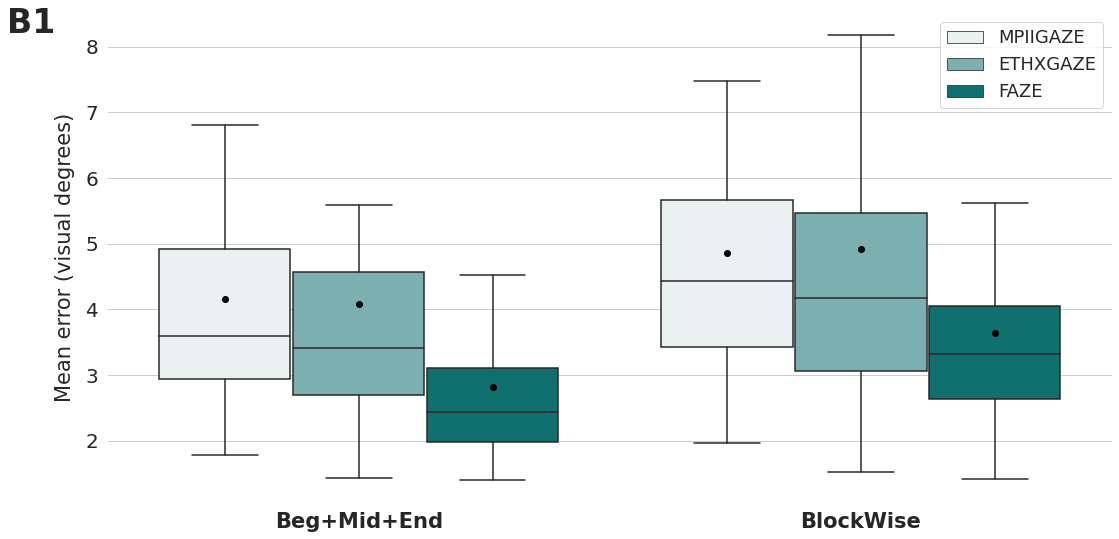

In [897]:
## Complete 65 subjects
plt.figure(figsize=(18,9))
temp = pd.concat([ct2_mpii, ct2_eth, ct2_faze], keys=["MPIIGAZE", "ETHXGAZE", "FAZE"], names=["Model"]).reset_index()
temp["acc_deg"] = temp.acc/54.05
sns.boxplot(x="factor", y="acc_deg", hue="Model", data = temp, color="teal", showfliers = False,  showmeans=True, meanprops={"marker":"o", "markerfacecolor":"black", "markeredgecolor":"black"})
plt.xticks(fontsize=21, fontweight = 800)
plt.yticks(fontsize = 20, fontweight = 520)
plt.legend(fontsize=18)
plt.xlabel('')
plt.ylabel('Mean error (visual degrees)', fontsize=21, fontweight = 549, labelpad=10)
plt.title("B1", loc='left', position = (-0.1,0), fontsize=33, fontweight=550, va = 'top')
# sns.swarmplot(x="factor", y="acc_deg", hue="Model", data = temp, color="teal")
sns.despine(left=True, bottom=True)
plt.savefig("calib_final_plots/calibtest2.png", dpi = 300, bbox_inches='tight')


Text(0, 0.5, '')

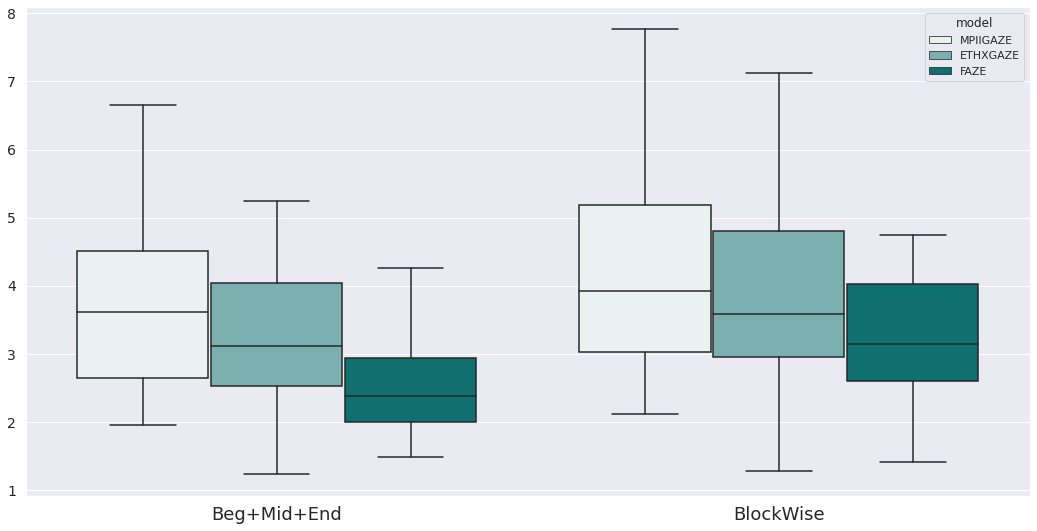

In [ ]:
## ETRA 41 Subjects
plt.figure(figsize=(18,9))
temp = pd.concat([ct2_mpii, ct2_eth, ct2_faze], keys=["MPIIGAZE", "ETHXGAZE", "FAZE"], names=["Model"]).reset_index()
temp["acc_deg"] = temp.acc/54.05
sns.boxplot(x="factor", y="acc_deg", hue="Model", data = temp, color="teal", showfliers = False)
plt.xticks(fontsize=18)
plt.yticks(fontsize = 14)
plt.xlabel('')
plt.ylabel('')
# plt.savefig("calib2_etra.png")

In [245]:
def ct2_run_tests(ct2_df, in_vis_deg = False, exclude_low_fps = False, pal = sns.color_palette('deep', 3)):
    ct2_df = ct2_df.copy()
    if in_vis_deg: 
        ct2_df["acc_deg"] = ct2_df.acc/54.05
        target = 'acc_deg'
    else: target = 'acc'
    
    if exclude_low_fps:
        ct2_df = ct2_df[~ct2_df.subject.isin(low_fps_subb)]
    
    print(ct2_df.groupby("factor")[target].agg(['count', 'max', 'mean', 'min', 'std']) , f"\n {'-'*122}")
#     print(AnovaRM(data=ct2_df, depvar='acc', subject='subject', within=['factor']).fit()) #depvar for ANOVA is acc not acc_deg
    print(pg.pairwise_ttests(dv='acc', within='factor', subject='subject', padjust='bonf', data = ct2_df).to_markdown(index=False), "\n")
    sns.set(rc={'figure.figsize':(16,12)})
    sns.boxplot(x="factor", y=target, data = ct2_df, color=pal[2], showfliers = False)
#     sns.swarmplot(x="factor", y=target, data = ct2_df[~ct2_df.subject.isin(low_fps_subb)], color = pal[0])
#     if not exclude_low_fps: sns.swarmplot(x="factor", y=target, data = ct2_df[ct2_df.subject.isin(low_fps_subb)], color = pal[1], marker = '<')
    plt.show()

             count        max      mean       min       std
factor                                                     
Beg+Mid+End     65  11.197258  4.159259  1.778638  1.833598
BlockWise       65  18.903090  4.852259  1.957046  2.564114 
 --------------------------------------------------------------------------------------------------------------------------
| Contrast   | A           | B         | Paired   | Parametric   |        T |   dof | alternative   |       p-unc |    BF10 |    hedges |
|:-----------|:------------|:----------|:---------|:-------------|---------:|------:|:--------------|------------:|--------:|----------:|
| factor     | Beg+Mid+End | BlockWise | True     | True         | -5.02313 |    64 | two-sided     | 4.33709e-06 | 3909.35 | -0.309078 | 



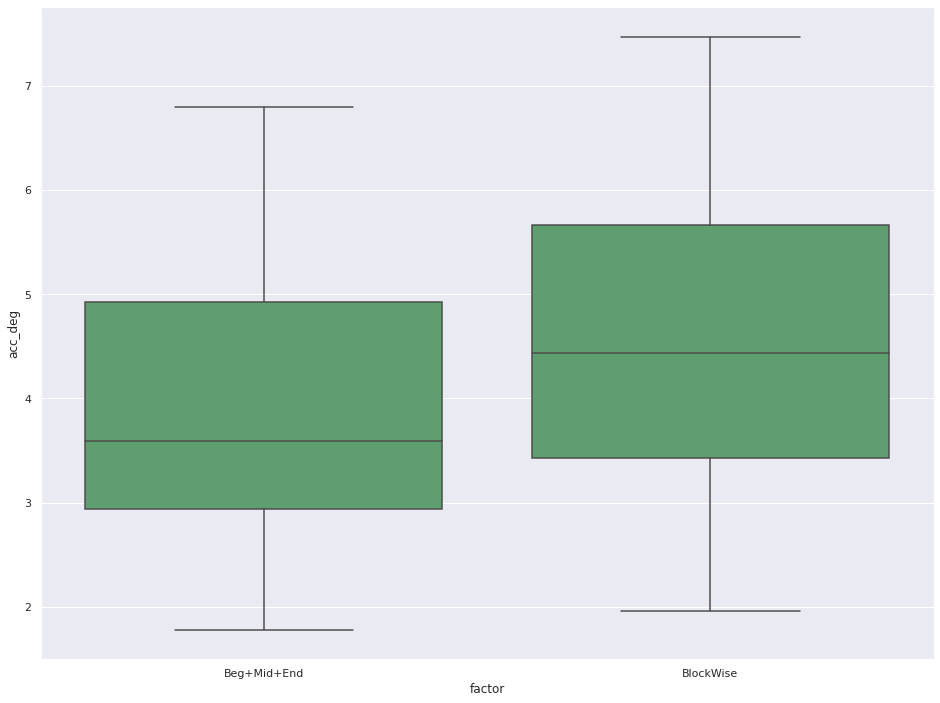

             count        max      mean       min       std
factor                                                     
Beg+Mid+End     65  19.629338  4.085426  1.432692  2.810484
BlockWise       65  16.931941  4.918290  1.518918  3.070097 
 --------------------------------------------------------------------------------------------------------------------------
| Contrast   | A           | B         | Paired   | Parametric   |        T |   dof | alternative   |       p-unc |    BF10 |    hedges |
|:-----------|:------------|:----------|:---------|:-------------|---------:|------:|:--------------|------------:|--------:|----------:|
| factor     | Beg+Mid+End | BlockWise | True     | True         | -4.27935 |    64 | two-sided     | 6.39298e-05 | 320.717 | -0.281322 | 



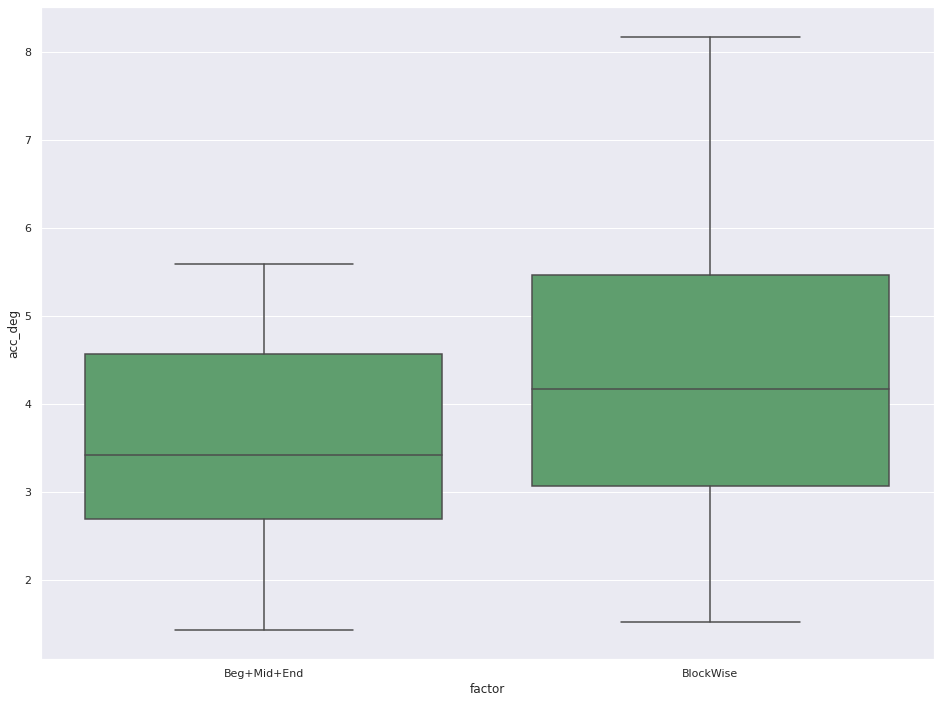

             count        max      mean       min       std
factor                                                     
Beg+Mid+End     65  11.029067  2.821400  1.398690  1.389888
BlockWise       65  11.453887  3.640208  1.413773  1.585338 
 --------------------------------------------------------------------------------------------------------------------------
| Contrast   | A           | B         | Paired   | Parametric   |        T |   dof | alternative   |       p-unc |      BF10 |    hedges |
|:-----------|:------------|:----------|:---------|:-------------|---------:|------:|:--------------|------------:|----------:|----------:|
| factor     | Beg+Mid+End | BlockWise | True     | True         | -10.3553 |    64 | two-sided     | 2.61776e-15 | 2.585e+12 | -0.546009 | 



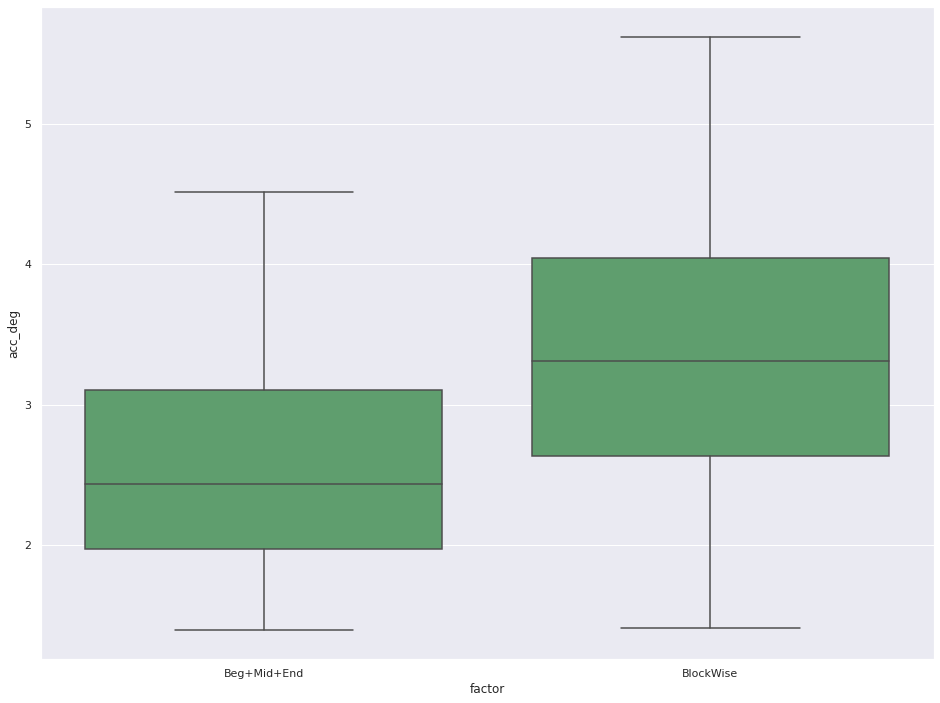

In [92]:
#model-wise statistical tests
ct2_run_tests(ct2_mpii, in_vis_deg=True)
ct2_run_tests(ct2_eth, in_vis_deg=True)
ct2_run_tests(ct2_faze, in_vis_deg=True)

## Single Calib Block Analysis

In [923]:
## Load Dfs
ct2_mpii = pd.read_csv("calib_tests_df/mpii_ct2_single_blocks.csv").set_index(["factor","subject"], verify_integrity=True)
ct2_eth = pd.read_csv("calib_tests_df/eth_ct2_single_blocks.csv").set_index(["factor","subject"], verify_integrity=True)
ct2_faze = pd.read_csv("calib_tests_df/faze_ct2_single_blocks.csv").set_index(["factor","subject"], verify_integrity=True)

In [931]:
ct2_comb = pd.concat([ct2_mpii, ct2_eth, ct2_faze], verify_integrity=True, names=["factor_model","factor_sample", "subject"], keys=["mpii","eth","faze"]).reset_index()

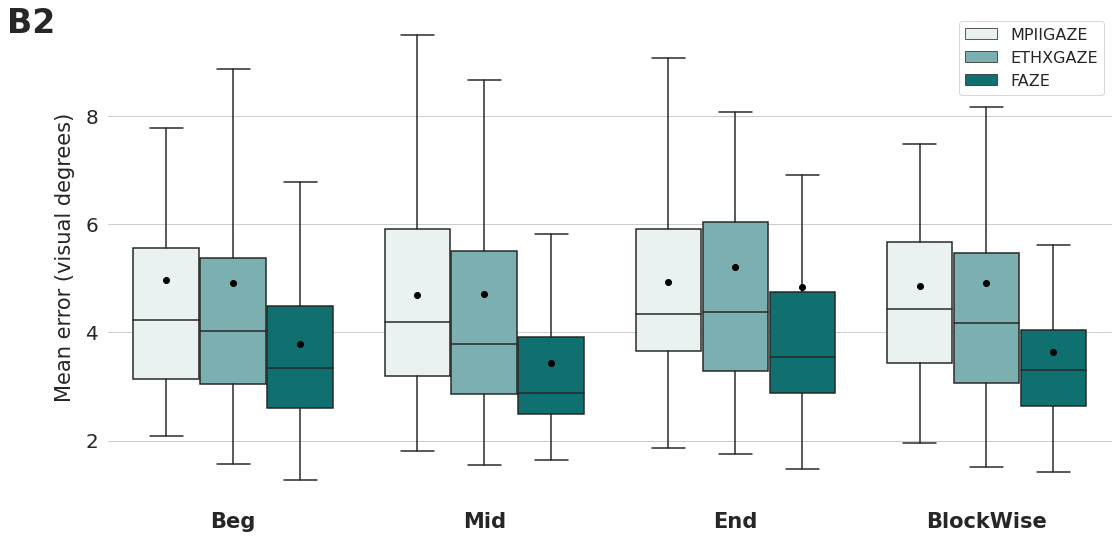

In [927]:
plt.figure(figsize=(18,9))
temp = pd.concat([ct2_mpii, ct2_eth, ct2_faze], keys=["MPIIGAZE", "ETHXGAZE", "FAZE"], names=["Model"]).reset_index()
temp["acc_deg"] = temp.acc/54.05
sns.boxplot(x="factor", y="acc_deg", hue="Model", data = temp, color="teal", showfliers = False, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"black", "markeredgecolor":"black"})
plt.xticks(fontsize=21, fontweight = 800)
plt.yticks(fontsize = 20, fontweight = 520)
plt.legend(fontsize=16)
plt.xlabel('')
plt.ylabel('Mean error (visual degrees)', fontsize=21, fontweight = 549, labelpad=10)
sns.despine(left=True, bottom=True)
plt.title("B2", loc='left', position = (-0.1,0), fontsize=33, fontweight=550, va = 'top')
# sns.swarmplot(x="factor", y="acc_deg", hue="Model", data = temp, color="teal")
plt.savefig("calib_final_plots/singleblock.png", dpi = 300, bbox_inches='tight')

In [ ]:
print("MPII"); print(ct2_mpii.groupby("factor").mean().sort_values("acc").to_markdown())
print("\nETHXGaze"); print(ct2_eth.groupby("factor").mean().sort_values("acc").to_markdown())
print("\nFAZE"); print(ct2_faze.groupby("factor").mean().sort_values("acc").to_markdown())

MPII
| factor    |     acc |
|:----------|--------:|
| Mid       | 253.451 |
| BlockWise | 262.267 |
| End       | 266.994 |
| Beg       | 268.385 |

ETHXGaze
| factor    |     acc |
|:----------|--------:|
| Mid       | 254.95  |
| Beg       | 265.36  |
| BlockWise | 265.834 |
| End       | 281.551 |

FAZE
| factor    |     acc |
|:----------|--------:|
| Mid       | 185.267 |
| BlockWise | 196.753 |
| Beg       | 204.232 |
| End       | 261.314 |


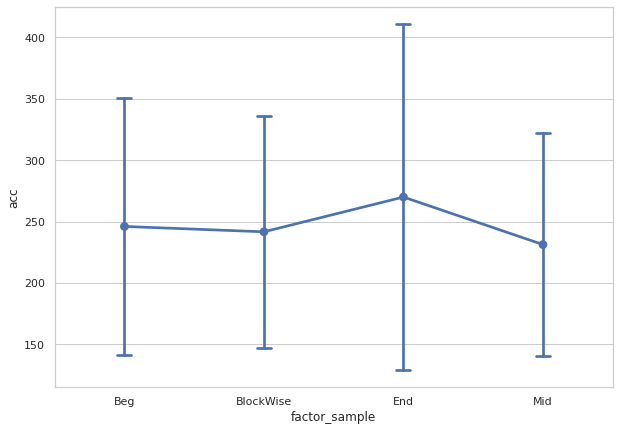

In [932]:
plt.figure(figsize=(10,7)); sns.pointplot(data=ct2_comb.groupby(["factor_sample","subject"]).mean().reset_index(), x='factor_sample', y='acc', capsize=.1, ci='sd'); plt.show()

In [933]:
rm_anova(data=ct2_comb.groupby(["factor_sample","subject"]).mean().reset_index(), dv = 'acc', within = 'factor_sample', subject='subject')#, detailed = True, effsize = 'n2')

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,factor_sample,3,192,4.188643,0.006718,0.030506,0.061427,0.468741,False,0.041812,4.997461e-41


In [935]:
avg_samples = pd.concat([ct2_mpii,ct2_eth,ct2_faze])
avg_samples = avg_samples.groupby(["subject","factor"]).mean().reset_index() #mean over models
avg_samples["acc_deg"] = avg_samples["acc"]/54.05
print(avg_samples.groupby("factor").mean().sort_values("acc").reset_index().to_markdown(), end="\n\n")
print(pg.pairwise_ttests(dv='acc', within='factor', subject='subject', padjust='bonf', data = avg_samples).to_markdown())

|    | factor    |     acc |   acc_deg |
|---:|:----------|--------:|----------:|
|  0 | Mid       | 231.223 |   4.27794 |
|  1 | BlockWise | 241.618 |   4.47027 |
|  2 | Beg       | 245.992 |   4.5512  |
|  3 | End       | 269.953 |   4.99451 |

|    | Contrast   | A         | B         | Paired   | Parametric   |         T |   dof | alternative   |      p-unc |    p-corr | p-adjust   |   BF10 |     hedges |
|---:|:-----------|:----------|:----------|:---------|:-------------|----------:|------:|:--------------|-----------:|----------:|:-----------|-------:|-----------:|
|  0 | factor     | Beg       | BlockWise | True     | True         |  0.983412 |    64 | two-sided     | 0.329108   | 1         | bonf       |  0.216 |  0.0433347 |
|  1 | factor     | Beg       | End       | True     | True         | -1.51398  |    64 | two-sided     | 0.134954   | 0.809726  | bonf       |  0.402 | -0.190435  |
|  2 | factor     | Beg       | Mid       | True     | True         |  1.83244  |    64 |

In [936]:
print(pg.pairwise_tukey(dv='acc', between='factor', data = avg_samples).to_markdown()) #Tukey test

|    | A         | B         |   mean(A) |   mean(B) |      diff |      se |         T |   p-tukey |     hedges |
|---:|:----------|:----------|----------:|----------:|----------:|--------:|----------:|----------:|-----------:|
|  0 | Beg       | BlockWise |   245.992 |   241.618 |   4.37454 | 19.3655 |  0.225894 |  0.995927 |  0.0393918 |
|  1 | Beg       | End       |   245.992 |   269.953 | -23.9608  | 19.3655 | -1.2373   |  0.603718 | -0.215762  |
|  2 | Beg       | Mid       |   245.992 |   231.223 |  14.7699  | 19.3655 |  0.762693 |  0.871133 |  0.133     |
|  3 | BlockWise | End       |   241.618 |   269.953 | -28.3354  | 19.3655 | -1.46319  |  0.461341 | -0.255154  |
|  4 | BlockWise | Mid       |   241.618 |   231.223 |  10.3954  | 19.3655 |  0.536799 |  0.949984 |  0.093608  |
|  5 | End       | Mid       |   269.953 |   231.223 |  38.7307  | 19.3655 |  1.99999  |  0.190671 |  0.348762  |


## Calib Test 3

In [94]:
model=pred_path.ETH
labels=["E","SP","E+SP"]
ct3 = pd.DataFrame(columns = ["subject","factor","acc"])
for subb in tqdm(subjects): 
    fix_analyse = Fixation(subb, show = False)
    for factor in [1,2,3]: 
        trial_x, trial_y, *_ = fix_analyse.parse_trials(model, f"poly_x_{factor}", f"poly_y_{factor}", calib_test=3, show = False)
        acc = get_fix_acc(fix_analyse.gt_points, trial_x, trial_y)
        ct3 = ct3.append({"subject":subb, "factor": labels[factor-1], "acc":acc}, ignore_index = True)
ct3.to_csv(f"calib_tests_df/{model.name.lower()}_ct3.csv", index = False)

100%|██████████| 65/65 [40:24<00:00, 37.31s/it]


In [868]:
## Size of samples for E, SP and E+SP
from joblib import load
model = pred_path.ETH
df_shape = pd.DataFrame(columns=["E","SP","E+SP"])
for subb in glob.glob(os.path.join("/hpc/users/shreshth.saxena",model.value,"*")):
    E_shape = load(os.path.join(subb,"calib_test1/Beg+Mid+End/E_calib/y.joblib")).shape[0]
    SP_shape = load(os.path.join(subb,"calib_test1/Beg+Mid+End/SP_calib/y.joblib")).shape[0]
    ESP_shape = load(os.path.join(subb,"calib_test3/E+SP/y.joblib")).shape[0]
    df_shape.loc[subb.split("/")[-1],] = [E_shape, SP_shape, ESP_shape]

In [477]:
## Load dfs
ct3_mpii = pd.read_csv("calib_tests_df/mpii_ct3.csv")
ct3_eth = pd.read_csv("calib_tests_df/eth_ct3.csv")
ct3_faze = pd.read_csv("calib_tests_df/faze_ct3.csv")

In [478]:
ct3_comb = pd.merge(ct3_mpii,ct3_eth, on = ["subject", "factor"]).merge(ct3_faze, on = ["subject", "factor"])
ct3_comb = ct3_comb.set_index(["subject","factor"]).stack().reset_index()
ct3_comb.columns = ["subject","factor_sample","factor_model","acc"]
ct3_comb["factor_model"].replace({"acc_x": "mpii", "acc_y":"eth", "acc":"faze"}, inplace = True)
ct3_comb
print(AnovaRM(data=ct3_comb, depvar='acc', subject='subject', within=['factor_sample', 'factor_model']).fit())

                          Anova
                           F Value Num DF  Den DF  Pr > F
---------------------------------------------------------
factor_sample              15.7162 2.0000 128.0000 0.0000
factor_model               11.8859 2.0000 128.0000 0.0000
factor_sample:factor_model  2.3108 4.0000 256.0000 0.0583



In [482]:
from pingouin import rm_anova #Same test diff library
rm_anova(data=ct3_comb, dv = 'acc', within = ['factor_sample', 'factor_model'], subject='subject', detailed = True, effsize = 'n2')

/home/shreshth.saxena/.conda/envs/temp/lib/python3.7/site-packages/pingouin/distribution.py:485: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,n2,eps
0,factor_sample,22659.697513,2,128,11329.848756,15.716224,7.880041e-07,0.000054,0.006009,0.613993
1,factor_model,552598.835192,2,128,276299.417596,11.885909,1.841642e-05,0.000370,0.146537,0.624192
2,factor_sample * factor_model,4461.736642,4,256,1115.434161,2.310785,5.827694e-02,0.135469,0.001183,0.175942


In [348]:
tmp= ct3_comb[ct3_comb["factor_sample"]=="E+SP"][ct3_comb["factor_model"]=="mpii"].set_index("subject")
tmp.join(df_shape)[["acc","E+SP"]].astype(float).corr()

/home/shreshth.saxena/.conda/envs/temp/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,acc,E+SP
acc,1.000000,-0.582499
E+SP,-0.582499,1.000000


In [480]:
#FAZE is sig better than other two
mpii = ct3_mpii[["subject","acc"]].groupby("subject").mean()
eth = ct3_eth[["subject","acc"]].groupby("subject").mean()
faze = ct3_faze[["subject","acc"]].groupby("subject").mean()

mpii["model"] = "MPII"; eth["model"] = "ETHXGaze"; faze["model"] = "FAZE" 
avg_models = mpii.append(eth).append(faze).sort_values("subject")
print(pg.pairwise_ttests(dv='acc', within='model', subject='subject', padjust='bonf', data = avg_models).to_markdown())

|    | Contrast   | A        | B    | Paired   | Parametric   |         T |   dof | alternative   |       p-unc |      p-corr | p-adjust   |       BF10 |     hedges |
|---:|:-----------|:---------|:-----|:---------|:-------------|----------:|------:|:--------------|------------:|------------:|:-----------|-----------:|-----------:|
|  0 | model      | ETHXGaze | FAZE | True     | True         |  3.47318  |    64 | two-sided     | 0.000927654 | 0.00278296  | bonf       | 27.893     |  0.574706  |
|  1 | model      | ETHXGaze | MPII | True     | True         | -0.380041 |    64 | two-sided     | 0.705173    | 1           | bonf       |  0.146     | -0.0617577 |
|  2 | model      | FAZE     | MPII | True     | True         | -9.26254  |    64 | two-sided     | 1.97364e-13 | 5.92092e-13 | bonf       |  3.952e+10 | -0.820267  |


In [882]:
#get model wise accuracies, calculate mean acc over 3 models and convert to visual deg
temp = ct3_comb[ct3_comb["factor_sample"]=="E+SP"].pivot(index="subject", columns = "factor_model", values = "acc") 
temp["avg_acc"] = temp.mean(axis=1)
temp = temp/54.05


In [490]:
avg_samples = ct3_mpii.append(ct3_eth).append(ct3_faze)
avg_samples = avg_samples.groupby(["subject","factor"]).mean().reset_index()
avg_samples["acc_deg"] = avg_samples["acc"]/54.05
print(avg_samples.groupby("factor").mean().sort_values("acc").reset_index().to_markdown(), end="\n\n")
print(pg.pairwise_ttests(dv='acc', within='factor', subject='subject', padjust='bonf', data = avg_samples).to_markdown())

|    | factor   |     acc |   acc_deg |
|---:|:---------|--------:|----------:|
|  0 | E+SP     | 184.148 |   3.40699 |
|  1 | SP       | 192.36  |   3.55893 |
|  2 | E        | 199.377 |   3.68875 |

|    | Contrast   | A    | B    | Paired   | Parametric   |        T |   dof | alternative   |       p-unc |      p-corr | p-adjust   |       BF10 |     hedges |
|---:|:-----------|:-----|:-----|:---------|:-------------|---------:|------:|:--------------|------------:|------------:|:-----------|-----------:|-----------:|
|  0 | factor     | E    | E+SP | True     | True         |  6.21549 |    64 | two-sided     | 4.32192e-08 | 1.29658e-07 | bonf       | 301100     |  0.200445  |
|  1 | factor     | E    | SP   | True     | True         |  1.94454 |    64 | two-sided     | 0.0562273   | 0.168682    | bonf       |      0.796 |  0.0928537 |
|  2 | factor     | E+SP | SP   | True     | True         | -4.62221 |    64 | two-sided     | 1.89175e-05 | 5.67525e-05 | bonf       |    990.294 | -0

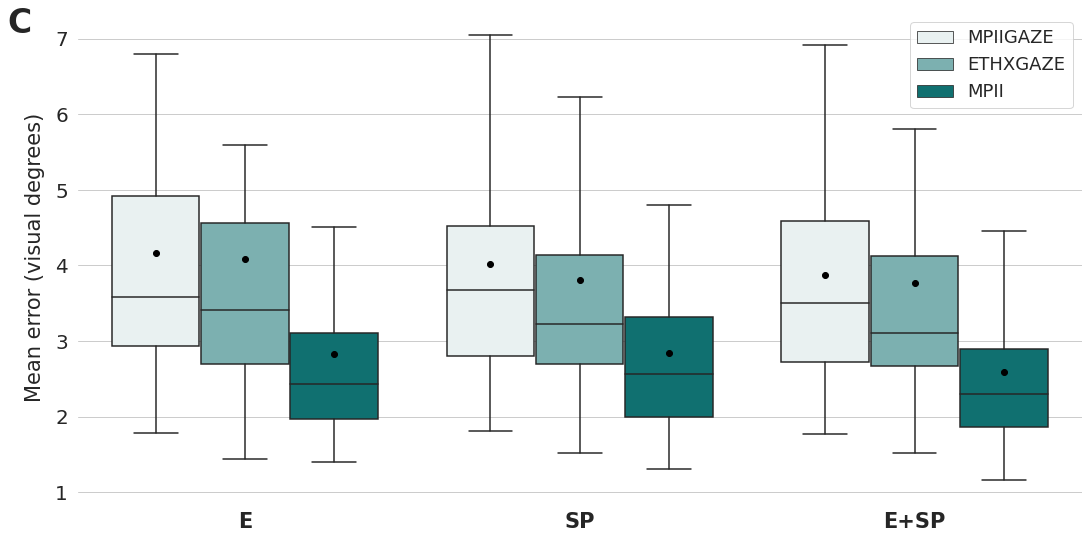

In [371]:
plt.figure(figsize=(18,9))
ct3_mpii = ct3_mpii[ct3_mpii["subject"].isin(subjects)].reset_index(drop=True)
ct3_eth = ct3_eth[ct3_eth["subject"].isin(subjects)].reset_index(drop=True)
ct3_faze = ct3_faze[ct3_faze["subject"].isin(subjects)].reset_index(drop=True)
temp = pd.concat([ct3_mpii, ct3_eth, ct3_faze], keys=["MPIIGAZE", "ETHXGAZE", "MPII"], names=["model"]).reset_index()
temp["acc_deg"] = temp.acc/54.05
sns.boxplot(x="factor", y="acc_deg", hue="model", data = temp, color="teal", showfliers = False,  showmeans=True, meanprops={"marker":"o", "markerfacecolor":"black", "markeredgecolor":"black"})
plt.xticks(fontsize=21, fontweight = 800)
plt.yticks(fontsize = 20, fontweight = 520)
plt.legend(fontsize=18)
plt.xlabel('')
plt.ylabel('Mean error (visual degrees)', fontsize=21, fontweight = 549, labelpad=10)
plt.title("C", loc='left', position = (-0.07,0), fontsize=33, fontweight=550, va = 'top')
# sns.swarmplot(x="factor", y="acc_deg", hue="Model", data = temp, color="teal")
sns.despine(left=True, bottom=True)
plt.savefig("calib_final_plots/calibtest3.png", dpi = 300, bbox_inches='tight')

In [103]:
def ct3_run_tests(ct3_df, in_vis_deg = False, exclude_low_fps = False, pal = sns.color_palette('deep', 3)):
    ct3_df = ct3_df.copy()
    if in_vis_deg: 
        ct3_df["acc_deg"] = ct3_df.acc/54.05
        target = 'acc_deg'
    else: target = 'acc'
    
#     if exclude_low_fps:
#         ct3_df = ct3_df[~ct3_df.subject.isin(low_fps_subb)]
    
    print(ct3_df.groupby("factor")[target].agg(['count', 'max', 'mean', 'min', 'std']))
    print(AnovaRM(data=ct3_df, depvar='acc', subject='subject', within=['factor']).fit()) #depvar for ANOVA is acc not acc_deg
    sns.set(rc={'figure.figsize':(16,12)})
    sns.boxplot(x="factor", y=target, data = ct3_df, color=pal[2], showfliers = False)
#     sns.swarmplot(x="factor", y=target, data = ct3_df[~ct3_df.subject.isin(low_fps_subb)], color = pal[0])
#     if not exclude_low_fps: sns.swarmplot(x="factor", y=target, data = ct3_df, color = pal[1], marker = '<')
    plt.show()

        count        max      mean       min       std
factor                                                
E          65  11.208970  4.159439  1.778638  1.834301
E+SP       65  10.213215  3.870817  1.765512  1.673364
SP         65  10.097063  4.022204  1.810623  1.742706
                Anova
       F Value Num DF  Den DF  Pr > F
-------------------------------------
factor  8.7938 2.0000 128.0000 0.0003



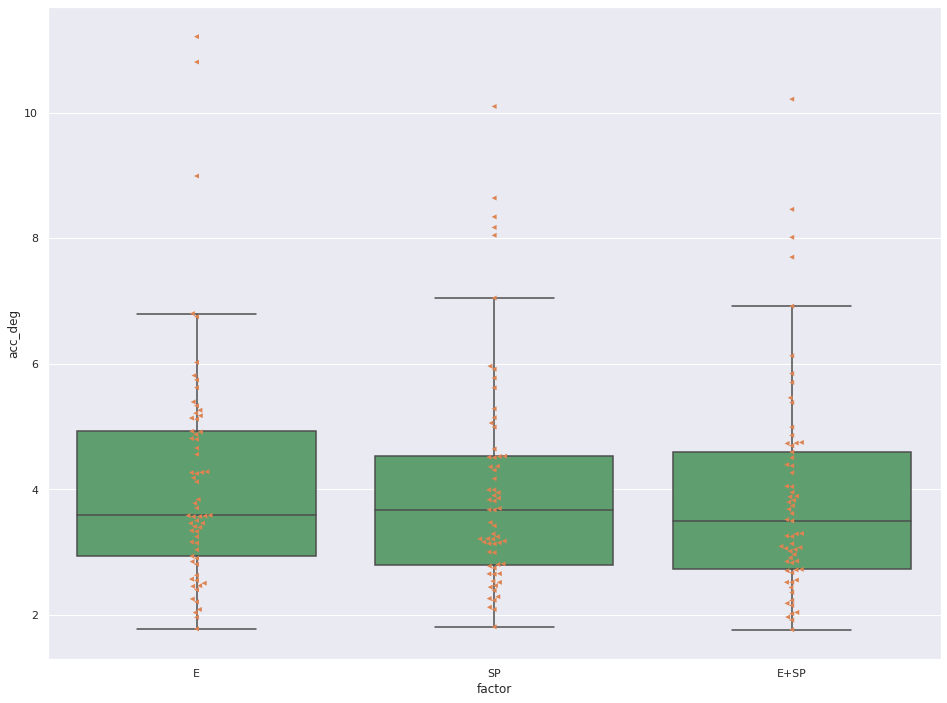

        count        max      mean       min       std
factor                                                
E          65  19.629338  4.085426  1.432692  2.810484
E+SP       65  15.823221  3.762969  1.511469  2.334535
SP         65  15.038470  3.810269  1.514586  2.258733
                Anova
       F Value Num DF  Den DF  Pr > F
-------------------------------------
factor  7.0943 2.0000 128.0000 0.0012



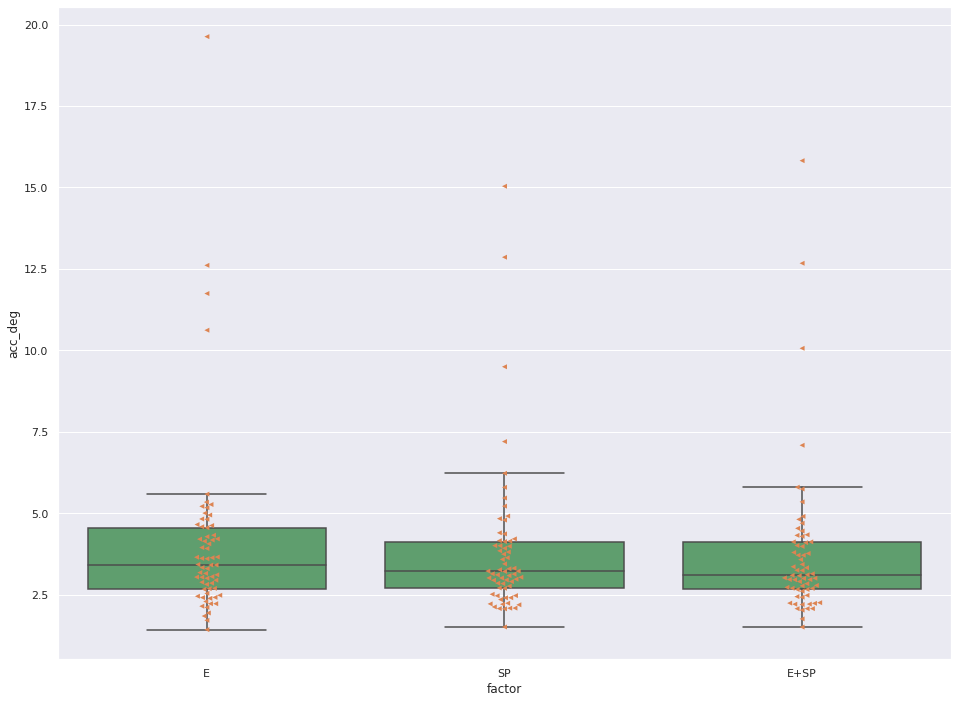

        count        max      mean       min       std
factor                                                
E          65  11.029067  2.821400  1.398690  1.389888
E+SP       65  10.727076  2.587190  1.159345  1.341436
SP         65  10.330374  2.844325  1.309193  1.342551
                Anova
       F Value Num DF  Den DF  Pr > F
-------------------------------------
factor  9.0550 2.0000 128.0000 0.0002



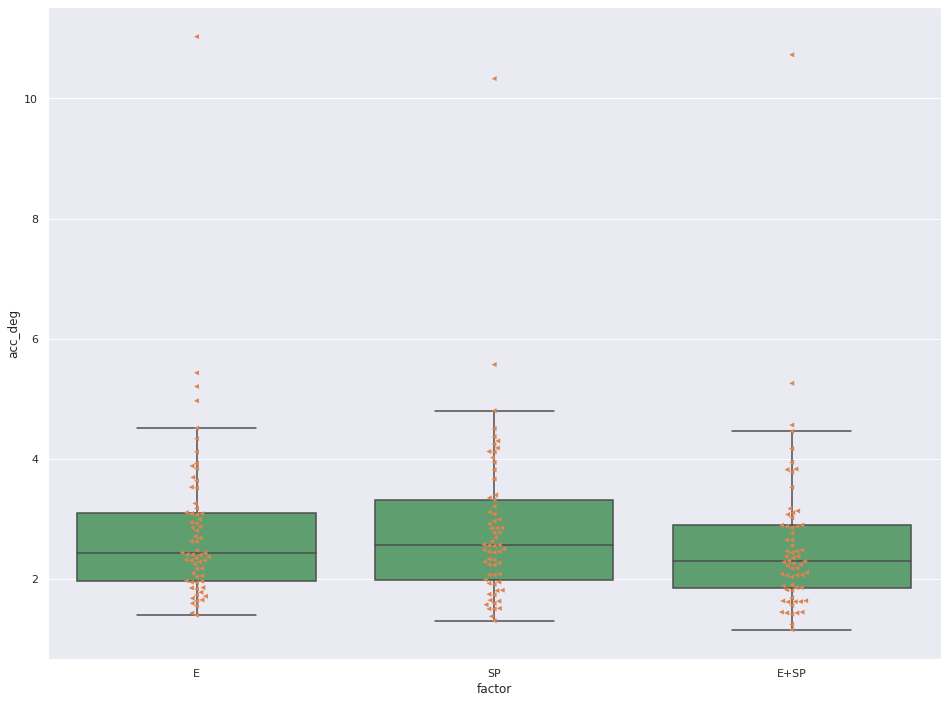

In [104]:
ct3_run_tests(ct3_mpii, in_vis_deg=True)
ct3_run_tests(ct3_eth, in_vis_deg=True)
ct3_run_tests(ct3_faze, in_vis_deg=True)

In [105]:
import pingouin as pg
print(pg.pairwise_ttests(dv='acc', within='factor', subject='subject', padjust='bonf', data = ct3_mpii).to_markdown())
print(pg.pairwise_ttests(dv='acc', within='factor', subject='subject', padjust='bonf', data = ct3_eth).to_markdown())
print(pg.pairwise_ttests(dv='acc', within='factor', subject='subject', padjust='bonf', data = ct3_faze).to_markdown())

|    | Contrast   | A    | B    | Paired   | Parametric   |        T |   dof | alternative   |       p-unc |      p-corr | p-adjust   |    BF10 |     hedges |
|---:|:-----------|:-----|:-----|:---------|:-------------|---------:|------:|:--------------|------------:|------------:|:-----------|--------:|-----------:|
|  0 | factor     | E    | E+SP | True     | True         |  4.23957 |    64 | two-sided     | 7.34268e-05 | 0.00022028  | bonf       | 282.264 |  0.163428  |
|  1 | factor     | E    | SP   | True     | True         |  1.53062 |    64 | two-sided     | 0.130791    | 0.392372    | bonf       |   0.411 |  0.0762563 |
|  2 | factor     | E+SP | SP   | True     | True         | -3.84865 |    64 | two-sided     | 0.000276705 | 0.000830116 | bonf       |  83.586 | -0.0880938 |
|    | Contrast   | A    | B    | Paired   | Parametric   |        T |   dof | alternative   |      p-unc |     p-corr | p-adjust   |   BF10 |     hedges |
|---:|:-----------|:-----|:-----|:---------|:----

In [106]:
from pingouin import rm_anova
rm_anova(data=ct3_comb, dv = 'acc', within = ['factor_sample', 'factor_model'], subject='subject', detailed = True, effsize = 'n2')

/home/shreshth.saxena/.conda/envs/temp/lib/python3.7/site-packages/pingouin/distribution.py:485: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,n2,eps
0,factor_sample,22659.697513,2,128,11329.848756,15.716224,7.880041e-07,0.000054,0.006009,0.613993
1,factor_model,552598.835192,2,128,276299.417596,11.885909,1.841642e-05,0.000370,0.146537,0.624192
2,factor_sample * factor_model,4461.736642,4,256,1115.434161,2.310785,5.827694e-02,0.135469,0.001183,0.175942


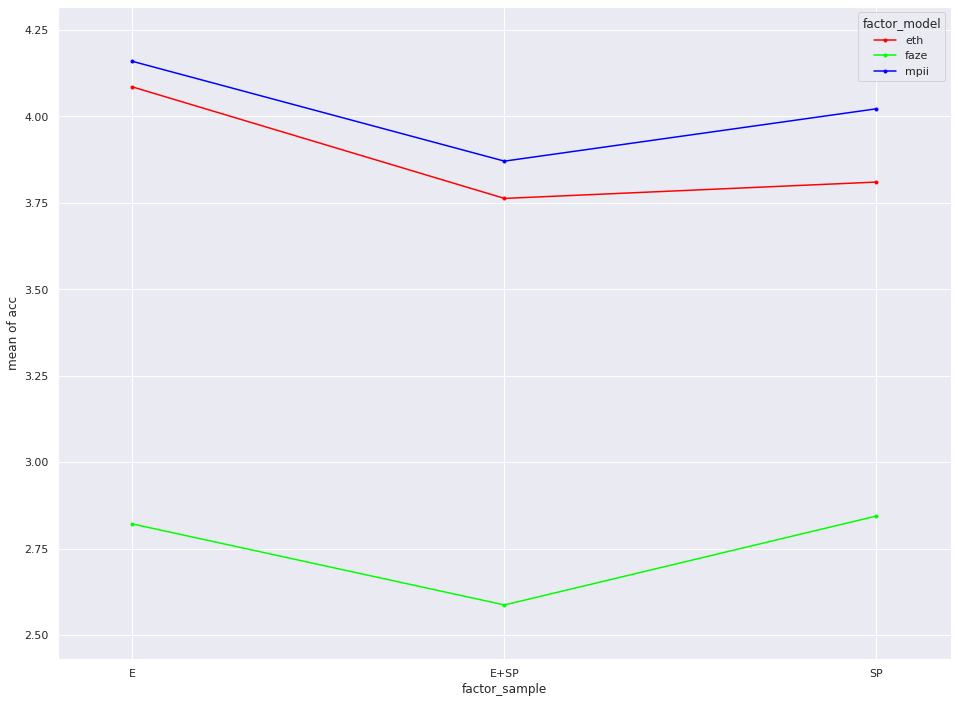

In [107]:
from statsmodels.graphics.factorplots import interaction_plot
# ct1_comb["acc_v"] = ct1_comb['acc']/54.05
interaction_plot(ct3_comb["factor_sample"], ct3_comb["factor_model"], ct3_comb["acc"]/54.05)
plt.show()

### Single Subject visualization

158.83202961595322


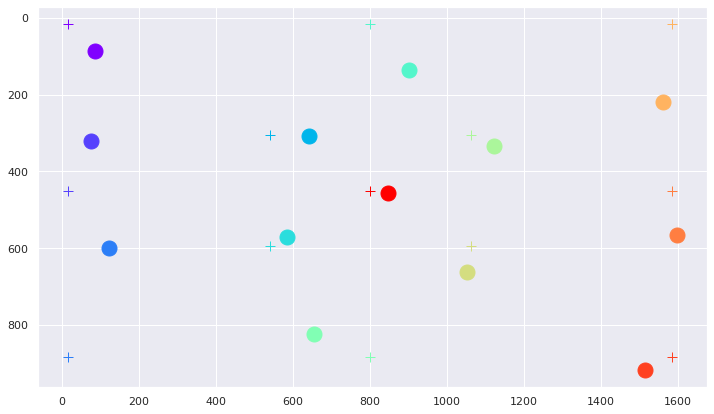

In [358]:
pallete = iter(cm.rainbow(np.linspace(0, 1, 13)))
plt.figure(figsize=(12,7))
fix_analyse = Fixation('s55', show = False)
trial_x, trial_y = fix_analyse.parse_trials(pred_path.FAZE,1, "poly_x_3", "poly_y_3", show = False)
print(get_fix_acc(fix_analyse.gt_points, trial_x, trial_y))
for key in range(1,14):
    c = next(pallete)
    pt = fix_analyse.gt_points[key-1]
    plt.plot(pt[0],pt[1], marker="+", markersize=10, color = c)
    
    X = winsorize(trial_x[key], limits=[0.1,0.1]).mean()
    Y = winsorize(trial_y[key], limits=[0.1,0.1]).mean()
    
#     X = statistics.median(trial_x[key])
#     Y = statistics.median(trial_y[key])
    plt.plot(X,Y, color = c, markersize = 15, marker = "o")
plt.gca().invert_yaxis()
plt.show()

### Single trial visualization

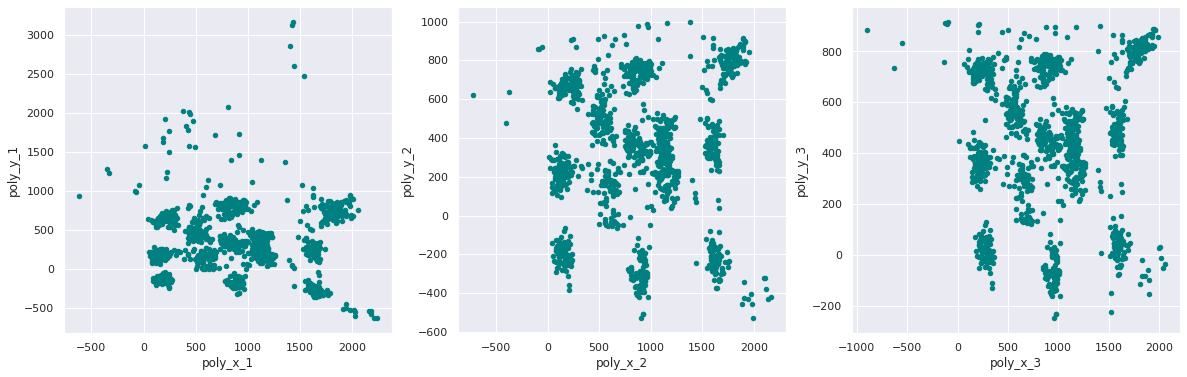

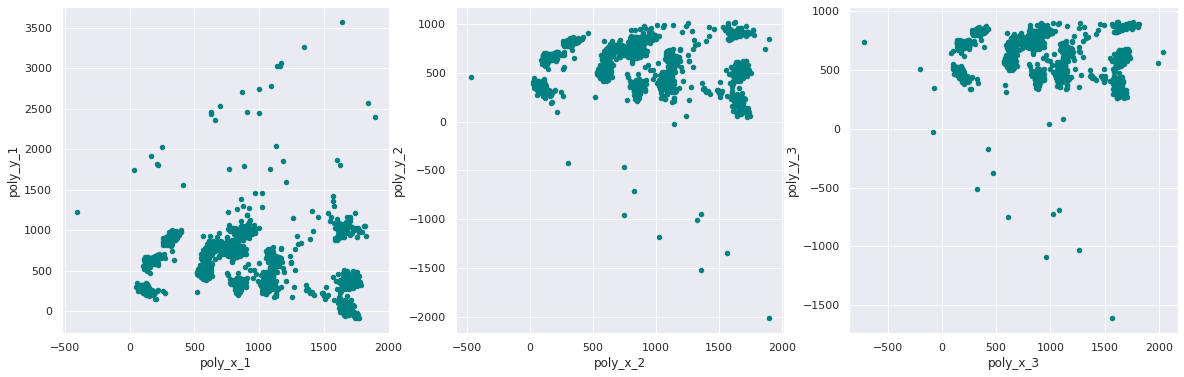

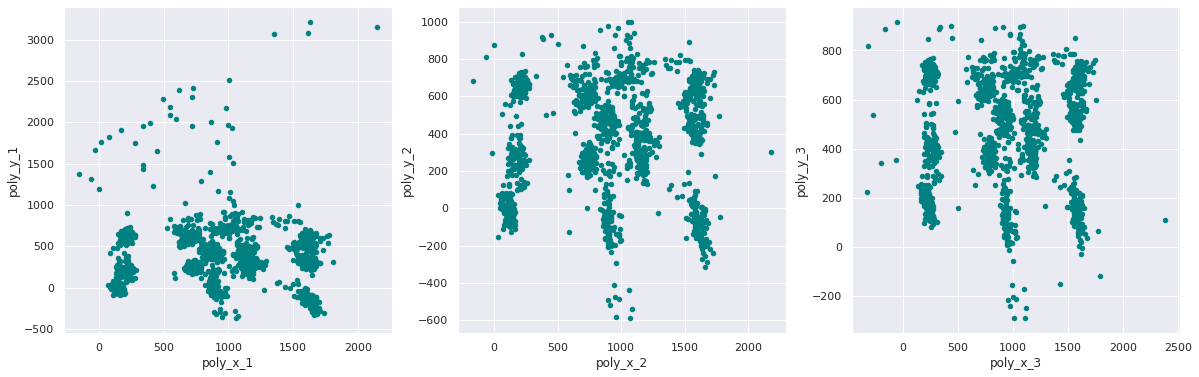

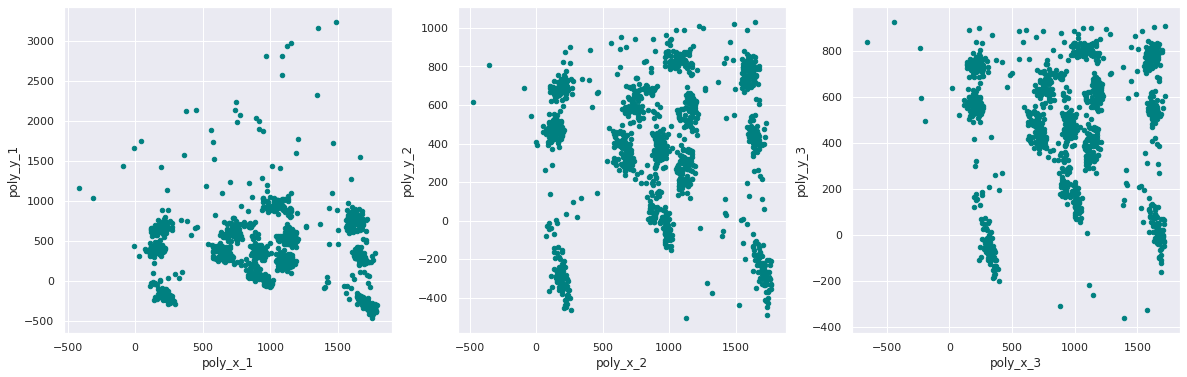

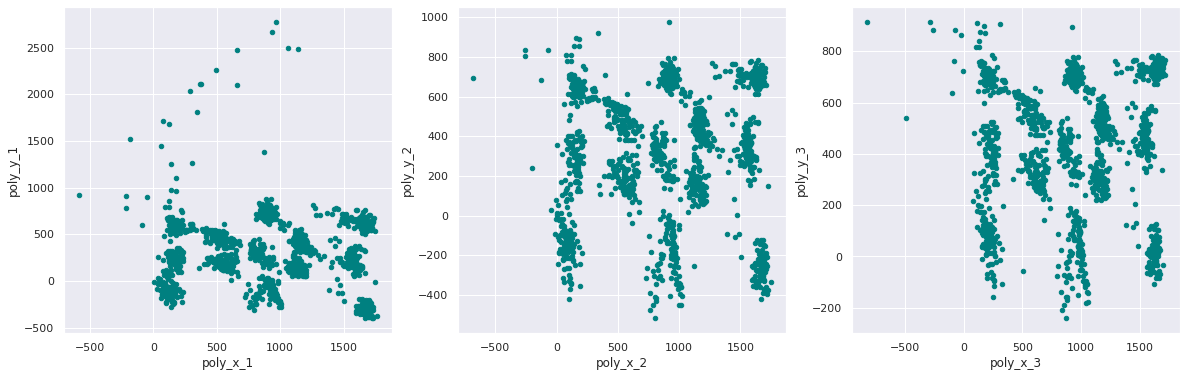

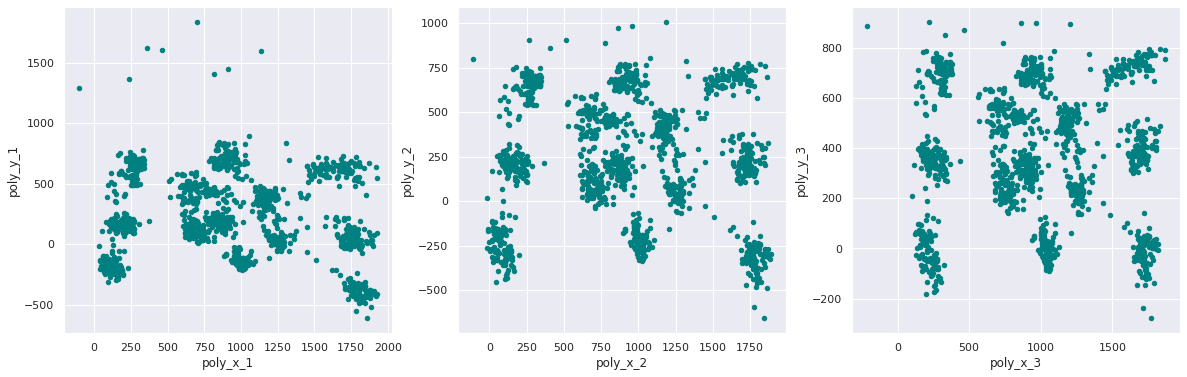

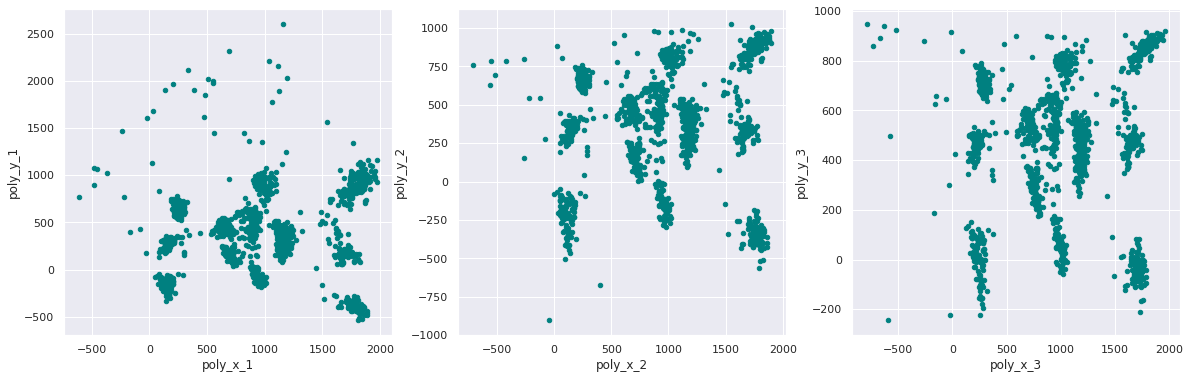

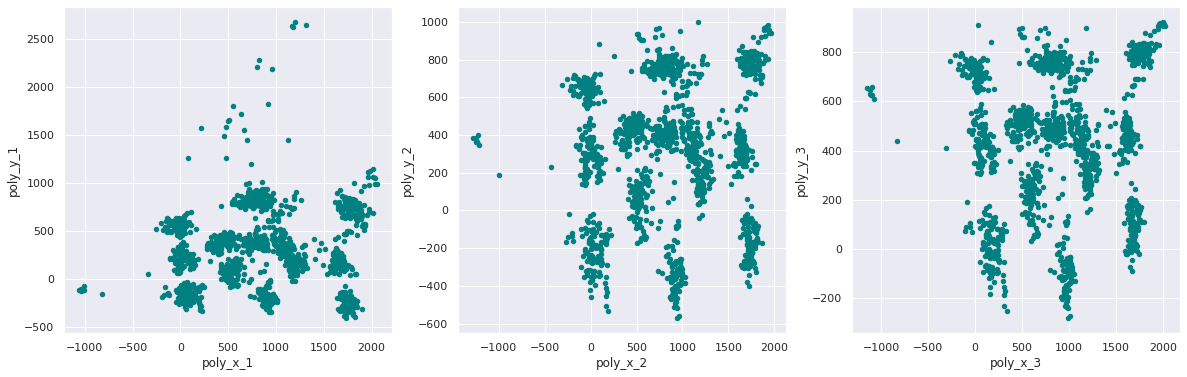

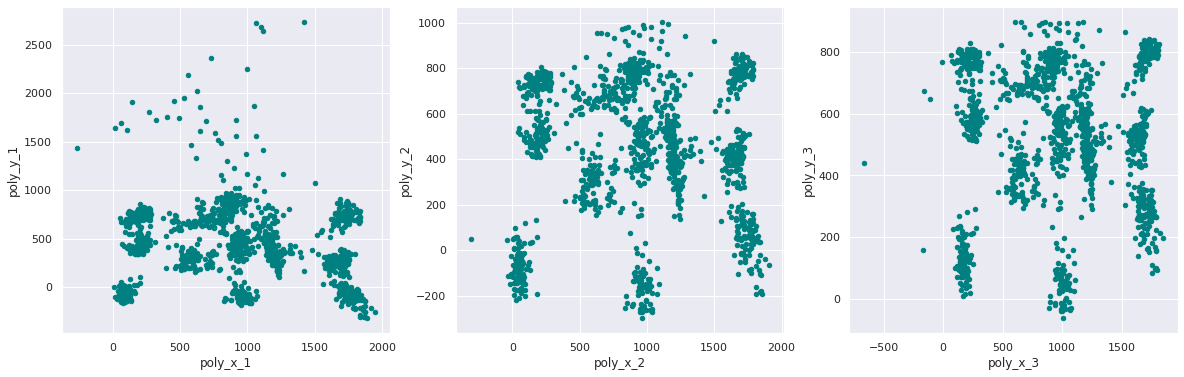

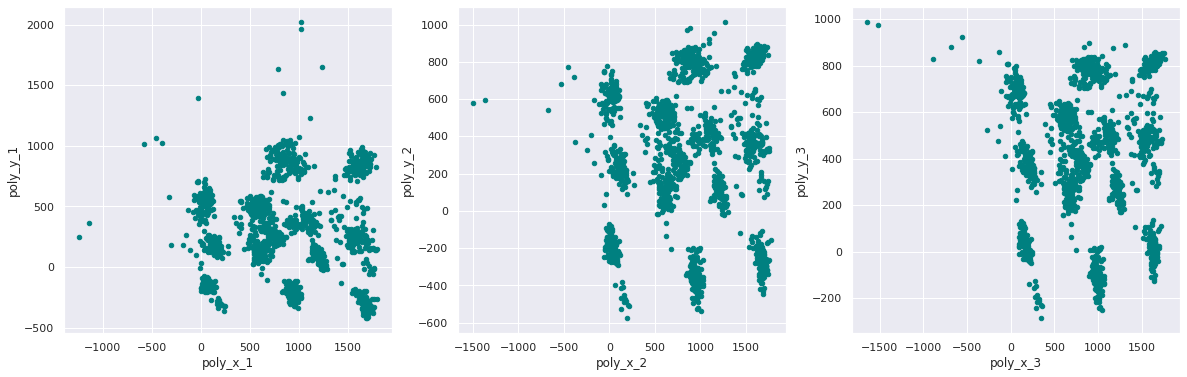

In [345]:
#all trieals for a subject
subb = "s17"
for path in glob.glob(pred_path.ETH.value+f'{subb}/calib_test1/outputs/*/*'):
        fig, axs = plt.subplots(1,3, figsize=(20,6))
        df = pd.read_csv(path)
        df.plot(x="poly_x_1", y = "poly_y_1", kind = "scatter", ax=axs[0], color ='teal')
        df.plot(x="poly_x_2", y = "poly_y_2", kind = "scatter", ax=axs[1], color='teal')
        df.plot(x="poly_x_3", y = "poly_y_3", kind = "scatter", ax=axs[2], color='teal')

### Effect of data size

In [895]:
df_shape = df_shape.iloc[:,:3].join(temp)  #drop(["acc","acc_deg", "factor"], axis=1)
df_shape.sort_values(by="avg_acc", inplace=True)
df_shape.columns = ["E_size", "SP_size", "E+SP_size", "ETHXGaze_acc", "FAZE_acc", "MPIIGaze_acc", "Avg_acc"] 
df_shape

,E_size,SP_size,E+SP_size,ETHXGaze_acc,FAZE_acc,MPIIGaze_acc,Avg_acc
s80,480,1248,1728,2.214253,1.159345,1.765512,1.713037
s60,480,1603,2083,2.032023,1.437482,2.357882,1.942462
s53,480,1809,2289,2.076198,1.904677,2.150644,2.043840
s110,480,1529,2009,2.078042,2.060744,2.040618,2.059801
s5,480,1423,1903,2.246871,1.419480,2.725303,2.130551
...,...,...,...,...,...,...,...
s9,480,955,1435,5.748309,3.833365,8.458812,6.013495
s59,480,883,1363,7.090333,4.565355,7.697635,6.451108
s61,480,1607,2087,15.823221,2.222969,2.018559,6.688250
s87,480,1495,1975,12.675234,3.944600,4.049449,6.889761


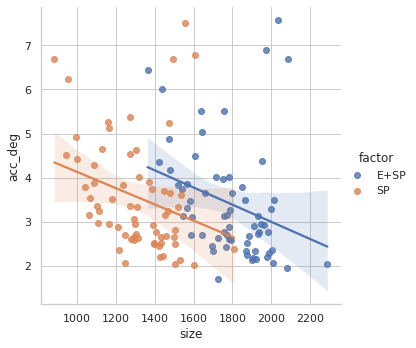

In [870]:
fac = "SP"
temp = df_shape.stack().reset_index().set_axis(["subject","factor","size"], axis=1)
temp = temp[temp.factor != "E"].set_index(["subject","factor"])
temp = avg_samples[avg_samples.factor!="E"].set_index(["subject","factor"]).join(temp.astype(int))
##MORE DATA = Low error | Better accuracy
sns.lmplot(x = "size",
            y = "acc_deg", 
            hue="factor",
            data = temp.reset_index())

In [894]:
df_shape[["E+SP_size","Avg_acc"]].astype(int).corr()

,E+SP_size,Avg_acc
E+SP_size,1.00000,-0.28675
Avg_acc,-0.28675,1.00000


In [893]:
from scipy.stats import pearsonr
pearsonr(df_shape["E+SP_size"], df_shape["Avg_acc"])

(-0.28310379266050606, 0.022304848234980808)

In [880]:
df_shape["E+SP_size"] = df_shape["E_size"]+df_shape["SP_size"]

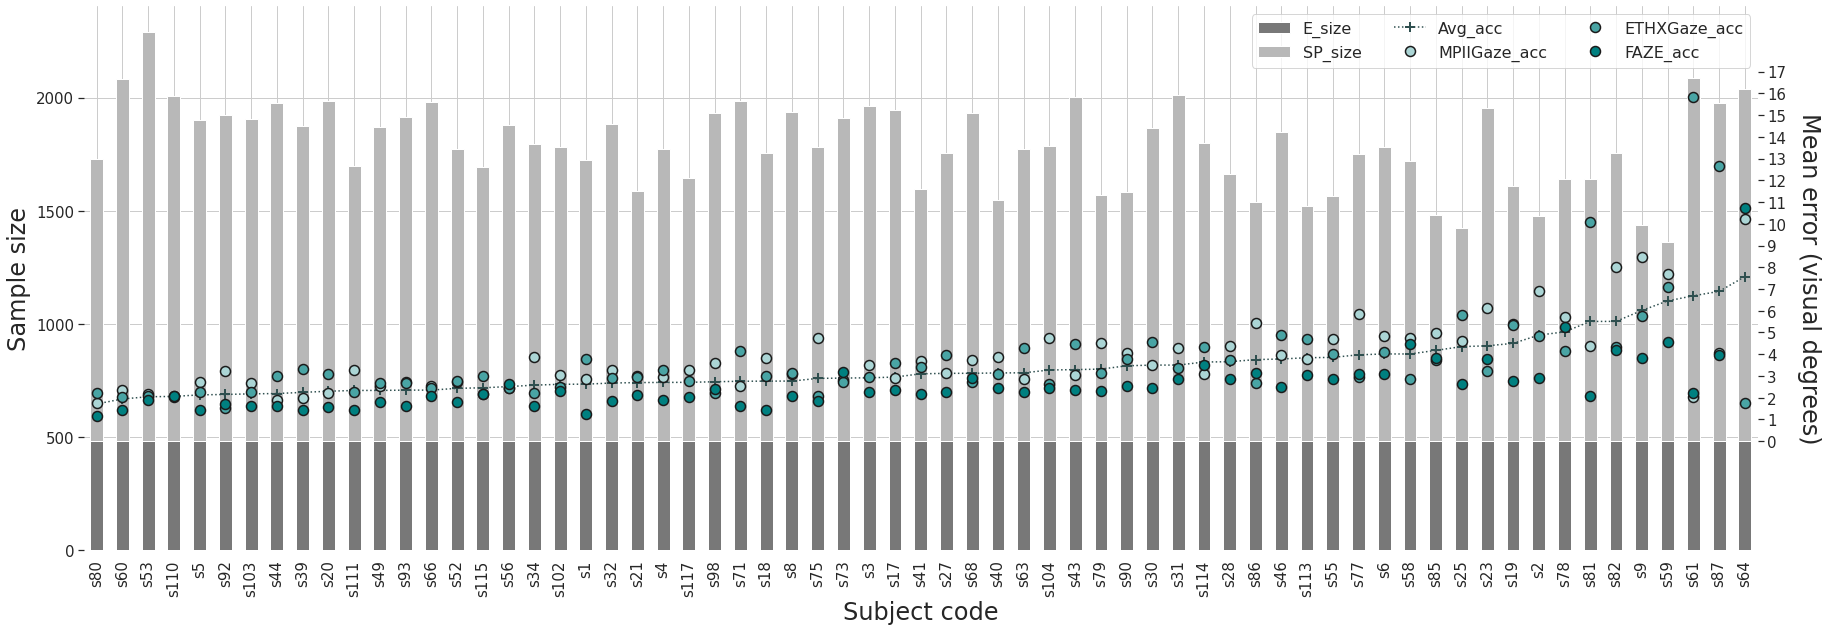

In [959]:
fig,ax1 = plt.subplots(figsize=(30,15))
ax2=ax1.twinx()
df_shape[["E_size","SP_size"]].plot(kind="bar",color=[sns.dark_palette("lightgrey",20)[i] for i in [9,16]],stacked=True, figsize=(30,10), ax=ax1, legend=False)
# ax1.bar(x=df_shape.index, height=df_shape["E+SP"], color="teal")
# ax2.plot(df_shape.index,df_shape.acc_deg, marker="o", markersize=12, color="darkslategrey")
df_shape[["Avg_acc"]].plot( color="darkslategrey", ax=ax2, legend=False, marker="+", markersize=10, markeredgewidth=2, linestyle=":")
df_shape[["MPIIGaze_acc","ETHXGaze_acc","FAZE_acc"]].plot(marker="o", markersize=10, markeredgewidth=1.5, markeredgecolor="k", colormap=ListedColormap([sns.light_palette("teal", 20)[i] for i in [5,13,19]]), ax=ax2, linestyle="", legend=False)
lns = ax1.get_legend_handles_labels()[0] + ax2.lines
labs = ax1.get_legend_handles_labels()[1] + [l.get_label() for l in lns[2:]]
ax1.legend(lns, labs, fontsize = 16, ncol=3, loc='upper right')
ax2.set_ylim(-5,20)
ax2.set_yticks(range(18))
sns.despine(left = True, bottom=True)
# ax1.legend(fontsize=16, loc='upper right')
ax1.set_ylabel("Sample size", fontsize=24, fontweight=500,labelpad=5)
ax2.set_ylabel("Mean error (visual degrees)", fontsize=24, fontweight=500, rotation=270, labelpad = 35)
ax1.set_xlabel("Subject code", fontsize=24, fontweight=500)
plt.grid(b=None)
plt.yticks(fontsize=15)
ax1.tick_params(axis='both', labelsize=15)
plt.savefig("calib_final_plots/df_shape_with_error.png", dpi=300,bbox_inches='tight') 